# Identifying Flood Damage with Convolution Neural Networks

### By: Mike McIntire



### BACKGROUND
Climate change is considered the greatest threat to society in the coming decades and will have far reaching effects on weather patterns, regional climates, wildlife, agriculture, property, and many other aspects of life on Earth. The planet is already experiencing some of the effects of climate change. In the western US, water is becoming scarcer, and fire season is lengthening and getting more costly [5]. In the South Pacific, people are being forced from their homes due to rising sea levels and lack of drinking water [6]. Along the Gulf coast of the US, residents must endure more frequent and stronger hurricanes capable of causing catastrophic flood damage. In August 2017, the Texas Gulf coast was hit by Hurricane Harvey. The storm made landfall on August 25th in Rockport, Texas as a category 4 storm. Over the next 5 days Harvey stalled over the Houston Metro area and dumped more than 27 trillion gallons of water on southeastern Texas. Some parts of Houston received up to 50 inches of rain during the storm [7]. The catastrophic flooding caused by the storm resulted in an approximately $125 billion in damage to properties and businesses in southeastern Texas. This is the second costliest storm in US history, only behind Hurricane Katrina in 2005.
### PURPOSE
As the effects of climate change continue to accelerate in the coming years, cleaning up after a natural disaster will become more complicated and costly. In the aftermath of Hurricane Harvey, many homes and businesses were severely damaged due to intense flooding. THE PROBLEM: Insurance companies and FEMA traditionally must drive through these areas to assess the damage and understand the economic costs. This can be a time consuming, expensive, and frequently dangerous task. SOLUTION: This study will attempt to improve the evaluation process using available satellite imagery and neural networks to identify areas affected by flooding. PROJECT VALUE: This study will be of great value for both the federal government and insurance companies who need to assess the costliness of a natural disaster. It can be implemented to help focus efforts on affected areas, cutting down the time an agent spends in a particular area and decreasing travel costs and potential harm.
### DATA
This dataset was taken from Kaggle.com [3] and was originally published on the IEEE website [1]. The authors of the dataset also wrote a paper detailing their approach and findings [2].  The data contains 23000 images of both damaged and undamaged classes. The data is broken into both training and test datasets. 
### EVALUATION
The results of each model will be evaluated based on the test accuracy score, precision and recall (in the form of a confusion matrix) and total time to run the models. It will be important to understand how each model is classifying the images with damaged homes and the images with un-damaged homes. I want to pick the model that correctly classifiys the most of these 

### 1. LOAD DATA

*Import key libraries*

In [ ]:
! pip install geopandas
import geopandas as gpd # geopandas for data distribution map

from google.colab import drive
drive.mount('/content/drive') # mount my drive to get image data

import shutil
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Activation
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, recall_score
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
import matplotlib.image as mpimg
import keras
from tensorflow.keras.models import model_from_json
import time

import matplotlib.style
import matplotlib as mpl
mpl.style.use('default') # set default style

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*Unzip image data from Drive*

In [ ]:
! unzip /content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/satellite-images-of-hurricane-damage.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_another/no_damage/-95.627453_29.859303000000004.jpeg  
  inflating: train_another/no_damage/-95.62745600000001_29.777524.jpeg  
  inflating: train_another/no_damage/-95.627485_29.777865999999996.jpeg  
  inflating: train_another/no_damage/-95.62751800000001_29.857785999999997.jpeg  
  inflating: train_another/no_damage/-95.62751999999999_29.860796999999998.jpeg  
  inflating: train_another/no_damage/-95.627523_29.770004999999998.jpeg  
  inflating: train_another/no_damage/-95.62753000000001_29.863289.jpeg  
  inflating: train_another/no_damage/-95.627539_29.827047999999998.jpeg  
  inflating: train_another/no_damage/-95.627543_29.860021000000003.jpeg  
  inflating: train_another/no_damage/-95.627563_29.8628.jpeg  
  inflating: train_another/no_damage/-95.627579_29.864051.jpeg  
  inflating: train_another/no_damage/-95.627595_29.776602.jpeg  
  inflating: train_another/no_damage/-95.62759799999999_29.777317.jpeg  
  i

*Move image folders to new folder*

In [ ]:
! mkdir /content/satellite-images-of-hurricane-damage
shutil.move('/content/test', '/content/satellite-images-of-hurricane-damage')
shutil.move('/content/test_another', '/content/satellite-images-of-hurricane-damage')
shutil.move('/content/train_another', '/content/satellite-images-of-hurricane-damage')
shutil.move('/content/validation_another', '/content/satellite-images-of-hurricane-damage')

*Create Pandas DataFrame*

In [ ]:
datadir = Path('/content/satellite-images-of-hurricane-damage') # pull file location w/ Path
location_df = pd.DataFrame({'path':list(datadir.glob('**/*.jp*g'))}) # create dataframe with one column
location_df.head()

,path
0,/content/satellite-images-of-hurricane-damage/...
1,/content/satellite-images-of-hurricane-damage/...
2,/content/satellite-images-of-hurricane-damage/...
3,/content/satellite-images-of-hurricane-damage/...
4,/content/satellite-images-of-hurricane-damage/...


In [ ]:
# use .map to extract labels and lat/lon coordinates from file path
location_df['label'] = location_df['path'].map(lambda x: x.parent.stem).astype(str)
location_df['location'] = location_df['path'].map(lambda x: x.stem).astype(str)
location_df['split'] = location_df['path'].map(lambda x: x.parent.parent.stem)
location_df['lat'] = location_df['location'].map(lambda x: float(x.split('_')[0])) #lat is first number, split _
location_df['lon'] = location_df['location'].map(lambda x: float(x.split('_')[-1]))#lon is second number, split _
location_df = location_df.drop(columns='location') # harvey dataframe will be used to view the data points on a map

# this data frame will be used for splitting data with train_test_split
path = pd.Series(location_df['path']).astype(str)
label = pd.Series(location_df['label'])
data = pd.concat([path, label], axis=1)
data.sample(5)

,path,label
22822,/content/satellite-images-of-hurricane-damage/...,damage
2315,/content/satellite-images-of-hurricane-damage/...,no_damage
10455,/content/satellite-images-of-hurricane-damage/...,no_damage
12494,/content/satellite-images-of-hurricane-damage/...,no_damage
4731,/content/satellite-images-of-hurricane-damage/...,no_damage


*Now that i've imported the data and created a DataFrame for the image file path's and labels it is time to split the data. I can do this in two ways. The authors of the dataset have already split the data into 4 seperate folders: train_another, test, validation_another, test_another. I could just create a DataFrame for each split label. Another option is to split the data myself using train_test_split(). Performing the split this way will insure the data is split correctly.*

## 2. Exploratory Data Analysis

*Compare all labels in dataset*

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 23.38159722222222, '')

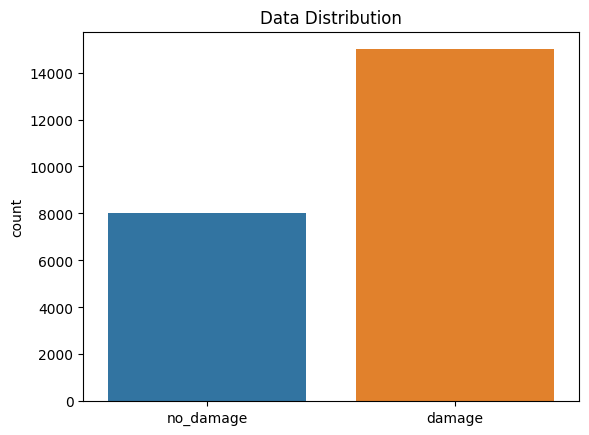

In [ ]:
# view label distribution
sns.countplot(data['label'])
plt.title('Data Distribution')
plt.savefig('/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/Saved_figures/data_distribution.jpeg', dpi=200) # save image to directory
plt.xlabel('')

In [ ]:
print('Damage images: ', data[data['label']=='damage'].shape[0])
print('No damage images: ', data[data['label']=='no_damage'].shape[0])

Damage images:  15000
No damage images:  8000


There are 15000 damaged images and 8000 un-damaged images

*Convert Pandas DataFrame to GeoPandas DataFrame*

In [ ]:
# convert location dataframe into Geopandas dataframe for map
location_gpd = gpd.GeoDataFrame(location_df, geometry=gpd.points_from_xy(location_df.lat, location_df.lon)) # set lat and lon for x and y
location_gpd.sample(5)

,path,label,split,lat,lon,geometry
2302,/content/satellite-images-of-hurricane-damage/...,no_damage,train_another,-95.158709,29.960916,POINT (-95.15871 29.96092)
19964,/content/satellite-images-of-hurricane-damage/...,damage,test_another,-95.629661,29.857461,POINT (-95.62966 29.85746)
7482,/content/satellite-images-of-hurricane-damage/...,damage,train_another,-96.901523,28.735025,POINT (-96.90152 28.73503)
183,/content/satellite-images-of-hurricane-damage/...,no_damage,train_another,-95.630859,29.770774,POINT (-95.63086 29.77077)
575,/content/satellite-images-of-hurricane-damage/...,no_damage,train_another,-96.973184,28.500312,POINT (-96.97318 28.50031)


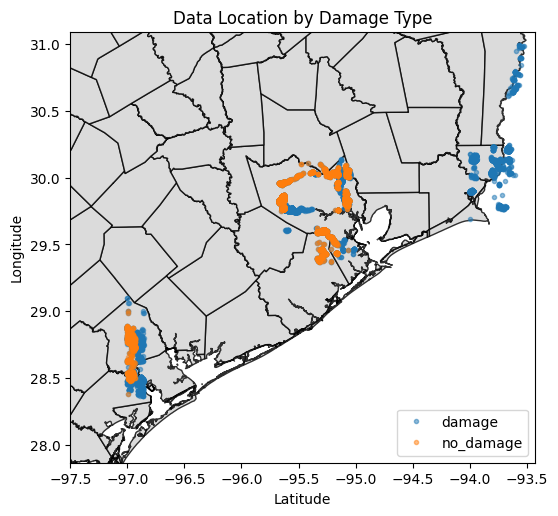

In [ ]:
# shape file of texas counties
texas = gpd.read_file('/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/Texas_County_Boundaries_Detailed-shp/County.shp') # texas counties taken from TXDOT website [8]

plt.rcParams['figure.figsize'] = (6,6)

ax1 = texas.plot(color='lightgrey', edgecolor='black', alpha=.8) # plot shapefile, light grey

# adding datapoints from harvey dataset onto map
for c_group, c_rows in location_gpd.groupby(['label']):
    ax1.plot(c_rows['lat'], c_rows['lon'], '.', label=c_group, alpha=0.5)
ax1.legend(loc='lower right')
# setting map extend to data point areas (se texas)
minx, miny, maxx, maxy = location_gpd.total_bounds
plt.title('Data Location by Damage Type')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
ax1.set_xlim(minx-0.5, maxx+0.1)
ax1.set_ylim(miny-0.5, maxy+0.1)
plt.savefig('/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/Saved_figures/data_location.jpeg', dpi=200)
plt.show()

*Using preprocessing.image_dataset_from_directory() to load data for display*

In [ ]:
train_ds, test_ds = train_test_split(data, test_size=0.20, stratify=data['label'], random_state=71)
train_ds.shape, test_ds.shape

((18400, 2), (4600, 2))

In [ ]:
print('Training Minority class ratio: {:.2f}'.format((train_ds[train_ds['label']=='no_damage'].shape[0])/(train_ds[train_ds['label']=='damage'].shape[0])))

Training Minority class ratio: 0.53


In [ ]:
print('Test Minority class ratio: {:.2f}'.format((test_ds[test_ds['label']=='no_damage'].shape[0])/(test_ds[test_ds['label']=='damage'].shape[0])))

Test Minority class ratio: 0.53


Train and test sets maintain the same ratio of damage vs. no_damage images

*Let's inspect the images prior to loading into the image generators*

In [ ]:
def get_image(file_path):
    return mpimg.imread(file_path)/255

(128, 128, 3)


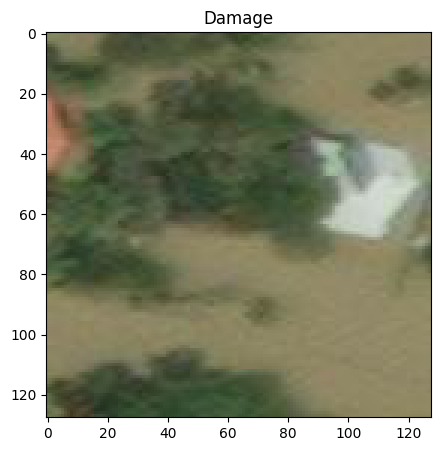

In [ ]:
train_image = get_image(train_ds[train_ds['label']=='damage']['path'].iloc[6])

fig = plt.figure(figsize=(5,5))
plt.title('Damage')
plt.imshow(train_image)
print(train_image.shape)

(128, 128, 3)


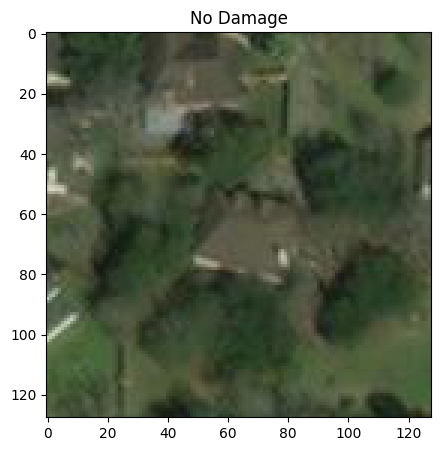

In [ ]:
test_image = get_image(test_ds[test_ds['label']=='no_damage']['path'].iloc[6])

fig =plt.figure(figsize=(5,5))
plt.title('No Damage')
plt.imshow(test_image)
print(test_image.shape)

## 3. Image data import and preprocessing

*Now I want to load my data through TensorFlow's ImageDataGenerator. This will generate batches of tensor image data with real-time image augmentation. Some of the augmentations that I will consider is image rotation, brightness, and horizontal/vertical flips. Since this is satellite data, it's logical to think we might view this data rotated (think Google Maps). It's also logical to increase or decrease the brightness of the images to mimic a bright sunny day or a cloudy day. We can also flip the data both horizontally and vertically and not lose the spatial meaning.* 

In [ ]:
img_height = 128
img_width = 128
batch_size = 100

In [ ]:
traingen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2, # rescale RGB data, split validation 80-20
                              rotation_range=90, brightness_range=[0.5, 1.5], # rotate images 90 degrees, decrease and increase brightness of augmented images (sun)
                              horizontal_flip=True, vertical_flip=True, #vertical and horizontal flips of the images
                              data_format='channels_last') # rgb channels go last 
testgen = ImageDataGenerator(rescale=1.0/255)

In [ ]:
train_set = traingen.flow_from_dataframe(dataframe=train_ds, x_col='path', y_col='label', 
                                         target_size=(img_height, img_width), color_mode='rgb', 
                                         batch_size=100,classes=['damage', 'no_damage'], class_mode='categorical', subset='training', shuffle=True)
valid_set = traingen.flow_from_dataframe(dataframe=train_ds, x_col='path', y_col='label', 
                                         target_size=(img_height, img_width), color_mode='rgb', 
                                         batch_size=100, classes=['damage', 'no_damage'], class_mode='categorical', subset='validation', shuffle=False)
test_set = testgen.flow_from_dataframe(dataframe=test_ds, x_col='path', y_col='label', 
                                       target_size=(img_height, img_width), color_mode='rgb', 
                                       batch_size=100, classes=['damage', 'no_damage'], class_mode='categorical', shuffle=False)

Found 14720 validated image filenames belonging to 2 classes.
Found 3680 validated image filenames belonging to 2 classes.
Found 4600 validated image filenames belonging to 2 classes.


*Since the data is imbalanced I will apply a 'balanced' class weights to the models. I'm experimenting with both applying weights and not.*

## CNN DISCUSSION

As defined by IBM, Computer vision is a field of AI that allows computers to gain meaningful insights from digital images, videos, and other visual inputs. To understand how computer vision works, we need to understand the general concepts of neural networks and deep learning. Neural networks, also known as artificial neural networks (ANNs) are the most important piece of the deep learning algorithms used today. Their name, structure, and interaction are based on the neurons in a human brain. ANNs are comprised of node layers with an input layer, one or more hidden layers, and an output layer. An image is nothing more than a matrix of pixel values and we can use this knowledge to build a deep learning model to classify items in an image. Imagine an image with a size of 50 pixels x 50 pixels. We’ll assume that this is a color image, so there are 3 channels: Red, Green, Blue. We can think of the image in terms of a matrix, where each pixel has a red, green, and blue associated value. These values collectively create an image which we can see and process in our minds. Computer vision resembles how humans classify images in their own brains, but we’ll make use of the matrices to help train the computer how to classify an image correctly. 

There are many different types of neural nets, each with a specific data application. The most popular method for computer vision and image classification is the Convolution Neural Network (CNN). CNNs are distinguished from other neural networks because of their exceptional performance on image data. They have three main types of layers: convolution layer, pooling layer, and the fully connected (FC) layer. With each layer the CNN increases in complexity, identify new features and recognizing larger elements of the object. I’ll briefly give a description of each of these layers and how they work.

*Convolution Layer*

The convolution layer is the primary layer in a CNN and is where most computation occurs. The convolution layer requires a few things. First, input data. Imagine again the 50 x 50 color image. A color image is considered a 3-dimensional image because of the red, green, and blue values for each pixel. This means that there are 3 2D matrices, one for each color, for the image. Next, we’ll use a feature detector, also known as a filter or kernel, which moves across an image according to the “stride” setting set by the author. The dot product is calculated between the input pixels and the kernel. These products are fed into a new 2D array. The final output of the dot products is called a convolution feature. What’s really cool about CNNs is that there is generally no dimensionality reduction required. The process of applying a kernel to the image and moving that kernel around to create a new convolution feature is considered dimensionality reduction. The kernel is applying weights to the input pixels and determining which pixels have the greatest impact on determining specific features in an image. Along with stride, another input to consider for the convolution layer is padding. This refers to how much space the kernel will leave when it reaches the edge of the image. Valid padding assumes no padding on the image. “Same” padding ensures that the output layer has the same size as the input layer. After a new feature map is created, we pass the it through an activation function, typically Rectified Linear Unit or ReLU. ReLU is a nonlinear function, which ensures that features will combine in interesting ways as they move deeper into the network.

*Pooling Layer*

Pooling layers are important because they conduct dimensionality reduction, reducing the number of parameters. Like the convolution layer, the pooling layer steps across the feature map, selecting the pixel with the largest value and sending that value to the output array. This process is referred to “max pooling,” which is what I use in this project. We can also use “average pooling,” which takes the average of all the values in the kernel and outputs to an array.

*Fully Connected Layer*

The fully connected layer provides the connections between the input and hidden layers and the output layer, which is the classification answer. 


## 4. Model Building

### *A. I'll start out with a simple model to get a baseline for the dataset*

In [ ]:
model = Sequential()

model.add(Dense(10, activation='relu', input_shape=(img_height,img_width,3)))
model.add(Dense(10, activation='relu'))

model.add(Flatten())
model.add(Dense(2, activation='sigmoid'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
ES1 = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5)
early_stopping1 = [ES1]
start = time.time()

simple_model = model.fit(train_set, batch_size=batch_size, epochs=50, steps_per_epoch=train_set.samples//batch_size, validation_steps=valid_set.samples//batch_size, verbose=1, validation_data=valid_set, callbacks=early_stopping1)

run_time = time.time() - start

Epoch 1/50
147/147 [==============================] - 74s 501ms/step - loss: 0.5969 - accuracy: 0.6906 - val_loss: 0.5319 - val_accuracy: 0.7467
Epoch 2/50
147/147 [==============================] - 73s 497ms/step - loss: 0.5153 - accuracy: 0.7505 - val_loss: 0.5030 - val_accuracy: 0.7667
Epoch 3/50
147/147 [==============================] - 73s 496ms/step - loss: 0.5010 - accuracy: 0.7679 - val_loss: 0.4854 - val_accuracy: 0.7764
Epoch 4/50
147/147 [==============================] - 73s 497ms/step - loss: 0.5016 - accuracy: 0.7655 - val_loss: 0.4892 - val_accuracy: 0.7789
Epoch 5/50
147/147 [==============================] - 73s 496ms/step - loss: 0.4895 - accuracy: 0.7771 - val_loss: 0.4805 - val_accuracy: 0.7775
Epoch 6/50
147/147 [==============================] - 73s 496ms/step - loss: 0.4976 - accuracy: 0.7655 - val_loss: 0.4937 - val_accuracy: 0.7831
Epoch 7/50
147/147 [==============================] - 73s 496ms/step - loss: 0.4835 - accuracy: 0.7788 - val_loss: 0.4762 - val_ac

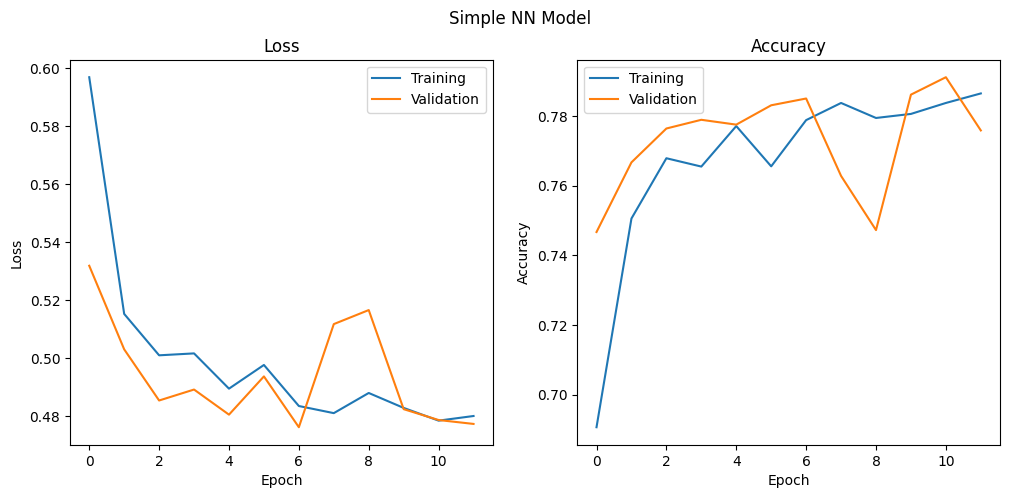

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))

ax1.plot(simple_model.history['loss'])
ax1.plot(simple_model.history['val_loss'])
ax1.set_title('Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['Training', 'Validation'])
ax2.plot(simple_model.history['accuracy'])
ax2.plot(simple_model.history['val_accuracy'])
ax2.set_title('Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['Training', 'Validation'])
fig.suptitle('Simple NN Model')
plt.show()

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 128, 128, 10)      40        
_________________________________________________________________
dense_27 (Dense)             (None, 128, 128, 10)      110       
_________________________________________________________________
flatten_9 (Flatten)          (None, 163840)            0         
_________________________________________________________________
dense_28 (Dense)             (None, 2)                 327682    
Total params: 327,832
Trainable params: 327,832
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_set.class_indices

{'damage': 0, 'no_damage': 1}

In [ ]:
train_pred = model.predict(train_set)
train_pred = np.argmax(train_pred,axis=1)

In [ ]:
print(classification_report(train_set.labels, train_pred))

              precision    recall  f1-score   support

           0       0.65      0.76      0.70      9583
           1       0.35      0.23      0.28      5137

    accuracy                           0.58     14720
   macro avg       0.50      0.50      0.49     14720
weighted avg       0.54      0.58      0.55     14720



In [ ]:
cm = confusion_matrix(train_set.labels, train_pred)

In [ ]:
# confusion matrix code taken from scikit-learn documentation[6].
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

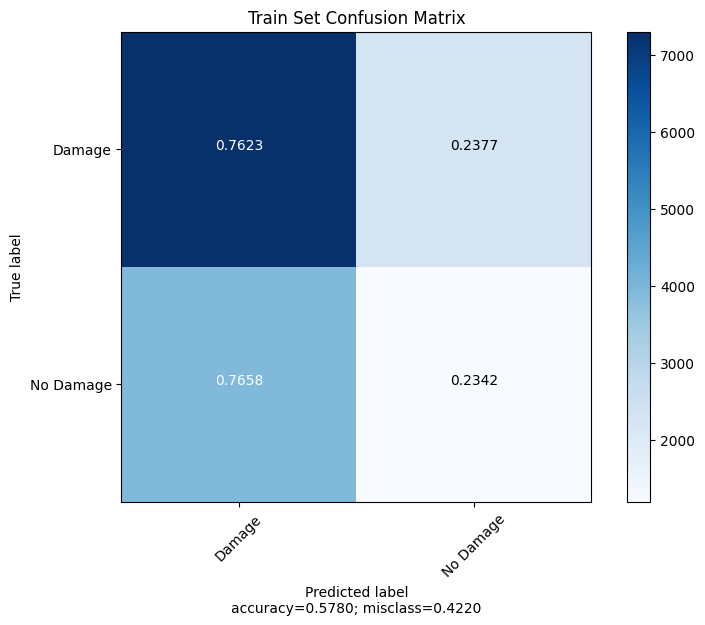

In [ ]:
plot_confusion_matrix(cm, target_names=['Damage', 'No Damage'], title='Train Set Confusion Matrix', normalize=True)

In [ ]:
test_pred = model.predict(test_set)
test_pred = np.argmax(test_pred,axis=1)
print(classification_report(test_set.labels, test_pred))

              precision    recall  f1-score   support

           0       0.84      0.52      0.65      3000
           1       0.48      0.81      0.60      1600

    accuracy                           0.62      4600
   macro avg       0.66      0.67      0.62      4600
weighted avg       0.71      0.62      0.63      4600



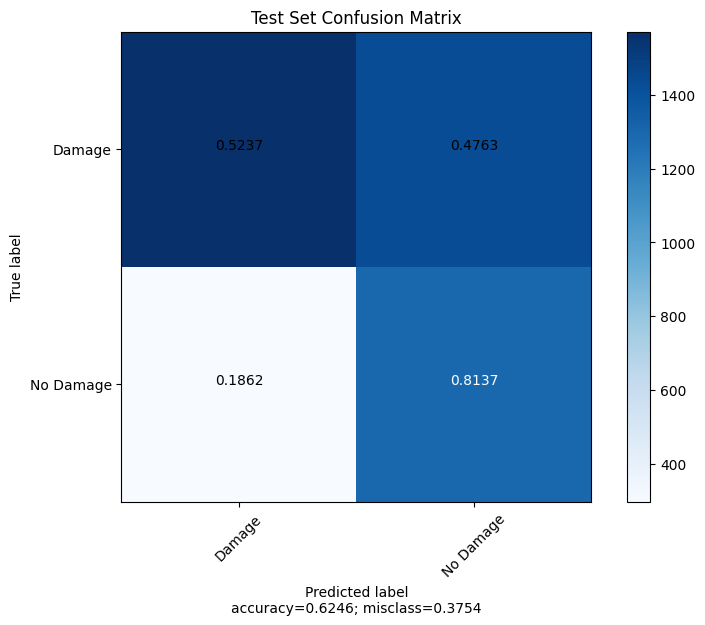

In [ ]:
cm = confusion_matrix(test_set.labels, test_pred)
plot_confusion_matrix(cm, target_names=['Damage', 'No Damage'], title='Test Set Confusion Matrix', cmap='Blues', normalize=True)

In [ ]:
score = model.evaluate(test_set, verbose=1)

46/46 [==============================] - 3s 57ms/step - loss: 0.6694 - accuracy: 0.6246


*Yikes. That model is pretty bad. Also, there is a large difference between the training and test set confusion matrices. In the training set, the model predicts the majority class better than the minority class. In the test set, the model predicts the minorty class much better, but does a poor job on the majority class. I'll continue on and run some different models, but there may be a larger issue with data leakage.* 

*Save model weights for later use*

In [ ]:
# save model to JSON
simple_model_json = model.to_json()
with open("/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/simple_model.json", "w") as json_file:
    json_file.write(simple_model_json)
# save weights to HDF5
model.save_weights("/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/simple_model_weights.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
json_file = open('/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/simple_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights('/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/simple_model_weights.h5')
print('Loaded model from disk')

Loaded model from disk


*I'll create a dictionary to store the model results for comparison at the end of the notebook* 

In [ ]:
results= {}
results['model']=[]
results['total_param']=[]
results['time']=[]
results['score']=[]

*save results to dictionary*

In [ ]:
#saving the model and histories
tf.keras.models.save_model(filepath='/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df', model=model)
model.save('/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df')
np.save('/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df/history_simple.npy', simple_model.history)
results['model'].append('simple_model')
results['total_param'].append(327832)
results['time'].append(run_time)
results['score'].append(score[1])

INFO:tensorflow:Assets written to: /content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df/assets


In [ ]:
results

{'model': ['simple_model'],
 'score': [0.6245652437210083],
 'time': [876.4248883724213],
 'total_param': [327832]}

### *B. Pretrained Model Experiment(VGG16)*

In [ ]:
pretrained_base = VGG16(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
pretrained_base.trainable = False

In [ ]:
model = Sequential()

model.add(pretrained_base)

model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))

model.add(Flatten())
model.add(Dense(2, activation='sigmoid'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
dense_29 (Dense)             (None, 4, 4, 10)          5130      
_________________________________________________________________
dense_30 (Dense)             (None, 4, 4, 10)          110       
_________________________________________________________________
flatten_10 (Flatten)         (None, 160)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 2)                 322       
Total params: 14,720,250
Trainable params: 5,562
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
ES1 = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5)
early_stopping1 = [ES1]
start = time.time()

pt_history = model.fit(train_set, batch_size=batch_size, steps_per_epoch=train_set.samples//batch_size, validation_steps=valid_set.samples//batch_size, epochs=50, validation_data=valid_set, callbacks=early_stopping1)

run_time = time.time() - start

Epoch 1/50
147/147 [==============================] - 75s 508ms/step - loss: 0.6870 - accuracy: 0.5457 - val_loss: 0.6712 - val_accuracy: 0.6264
Epoch 2/50
147/147 [==============================] - 73s 499ms/step - loss: 0.6661 - accuracy: 0.6486 - val_loss: 0.6558 - val_accuracy: 0.6842
Epoch 3/50
147/147 [==============================] - 74s 501ms/step - loss: 0.6548 - accuracy: 0.6744 - val_loss: 0.6466 - val_accuracy: 0.6933
Epoch 4/50
147/147 [==============================] - 74s 501ms/step - loss: 0.6452 - accuracy: 0.6865 - val_loss: 0.6388 - val_accuracy: 0.7033
Epoch 5/50
147/147 [==============================] - 74s 501ms/step - loss: 0.6374 - accuracy: 0.6940 - val_loss: 0.6296 - val_accuracy: 0.7069
Epoch 6/50
147/147 [==============================] - 74s 502ms/step - loss: 0.6281 - accuracy: 0.7019 - val_loss: 0.6216 - val_accuracy: 0.7169
Epoch 7/50
147/147 [==============================] - 74s 502ms/step - loss: 0.6178 - accuracy: 0.7098 - val_loss: 0.6091 - val_ac

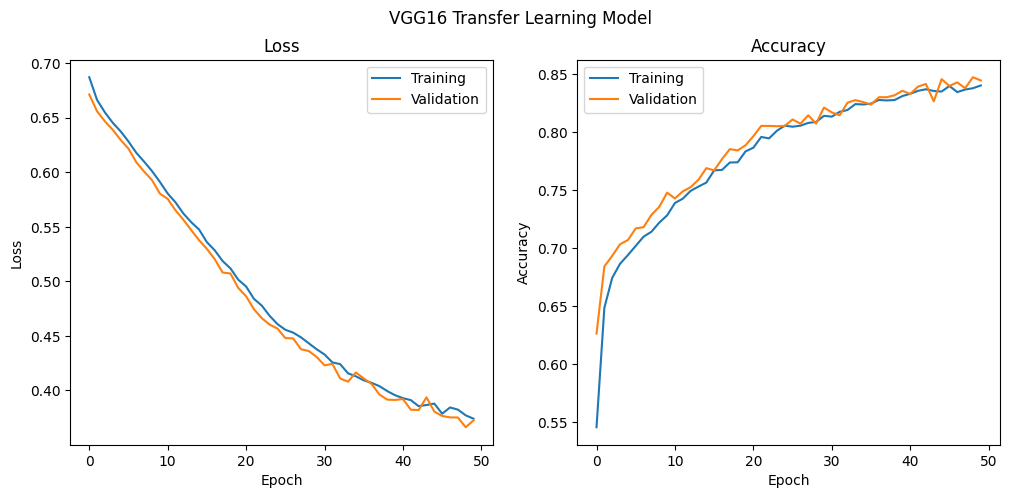

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))

ax1.plot(pt_history.history['loss'])
ax1.plot(pt_history.history['val_loss'])
ax1.set_title('Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['Training', 'Validation'])
ax2.plot(pt_history.history['accuracy'])
ax2.plot(pt_history.history['val_accuracy'])
ax2.set_title('Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['Training', 'Validation'])
fig.suptitle('VGG16 Transfer Learning Model')
plt.show()

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
dense_29 (Dense)             (None, 4, 4, 10)          5130      
_________________________________________________________________
dense_30 (Dense)             (None, 4, 4, 10)          110       
_________________________________________________________________
flatten_10 (Flatten)         (None, 160)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 2)                 322       
Total params: 14,720,250
Trainable params: 5,562
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
train_pred = model.predict(train_set)
train_pred = np.argmax(train_pred,axis=1)

In [ ]:
print(classification_report(train_set.labels, train_pred))

              precision    recall  f1-score   support

           0       0.65      0.71      0.68      9583
           1       0.35      0.30      0.32      5137

    accuracy                           0.57     14720
   macro avg       0.50      0.50      0.50     14720
weighted avg       0.55      0.57      0.56     14720



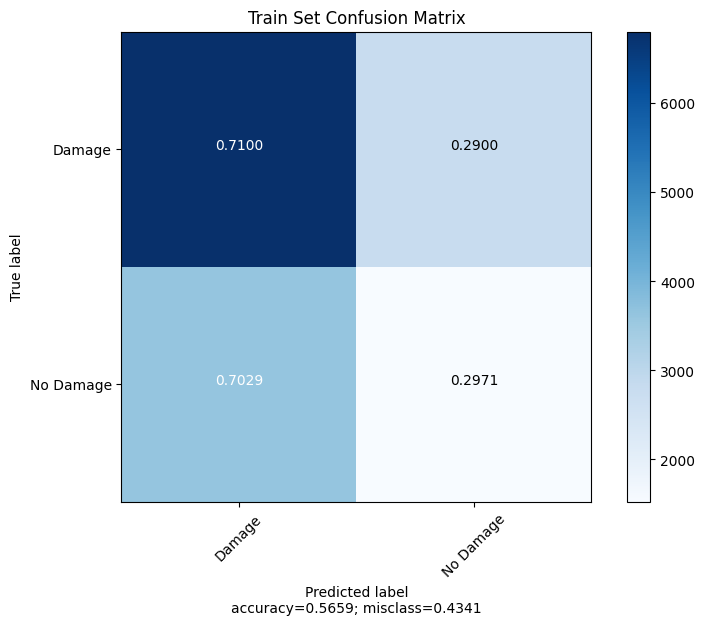

In [ ]:
cm = confusion_matrix(train_set.labels, train_pred)
plot_confusion_matrix(cm, target_names=['Damage', 'No Damage'], title='Train Set Confusion Matrix', cmap='Blues', normalize=True)

In [ ]:
test_pred = model.predict(test_set)
test_pred = np.argmax(test_pred,axis=1)

print(classification_report(test_set.labels, test_pred))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      3000
           1       0.88      0.73      0.80      1600

    accuracy                           0.87      4600
   macro avg       0.88      0.84      0.85      4600
weighted avg       0.87      0.87      0.87      4600



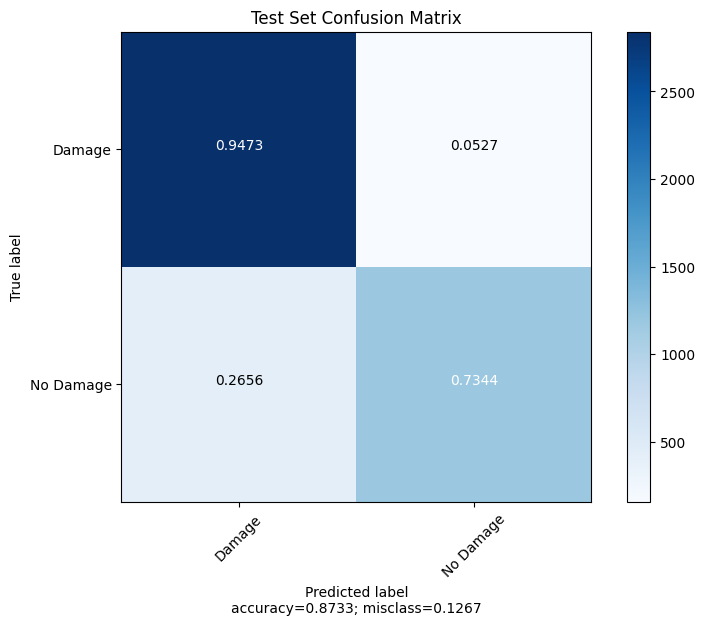

In [ ]:
cm = confusion_matrix(test_set.labels, test_pred)
plot_confusion_matrix(cm, target_names=['Damage', 'No Damage'], title='Test Set Confusion Matrix', cmap='Blues', normalize=True)

In [ ]:
valid_pred = model.predict(valid_set)
valid_pred = np.argmax(valid_pred,axis=1)

print(classification_report(valid_set.labels, valid_pred))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      2417
           1       0.82      0.69      0.75      1263

    accuracy                           0.84      3680
   macro avg       0.83      0.81      0.82      3680
weighted avg       0.84      0.84      0.84      3680



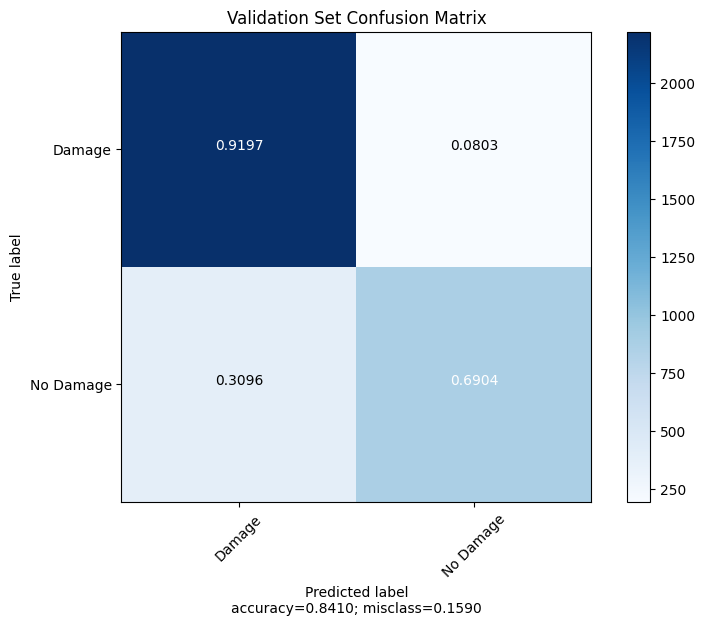

In [ ]:
cm = confusion_matrix(valid_set.labels, valid_pred)
plot_confusion_matrix(cm, target_names=['Damage', 'No Damage'], title='Validation Set Confusion Matrix', cmap='Blues', normalize=True)

In [ ]:
score = model.evaluate(test_set, verbose=1)

46/46 [==============================] - 3s 67ms/step - loss: 0.3469 - accuracy: 0.8733


In [ ]:
# save model to JSON
pt_model_json = model.to_json()
with open("/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/vgg16_model.json", "w") as json_file:
    json_file.write(pt_model_json)
# save weights to HDF5
model.save_weights("/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/vgg16_model_weights.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
#saving the model and histories
tf.keras.models.save_model(filepath='/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df', model=model)
model.save('/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df')
np.save('/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df/history_vgg16.npy', pt_history.history)
results['model'].append('VGG16')
results['total_param'].append(14720250)
results['time'].append(run_time)
results['score'].append(score[1])

INFO:tensorflow:Assets written to: /content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df/assets


In [ ]:
results

{'model': ['simple_model', 'VGG16'],
 'score': [0.6245652437210083, 0.8732608556747437],
 'time': [876.4248883724213, 3680.210971593857],
 'total_param': [327832, 14720250]}

### *B-2. Pretrained Model (ResNet)*

In [ ]:
resnet_pretrained_base = ResNet50(include_top=False, weights='imagenet', input_shape=(128,128,3))
resnet_pretrained_base.trainable = False

In [ ]:
model = Sequential()

model.add(resnet_pretrained_base)

model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))

model.add(Flatten())
model.add(Dense(2, activation='sigmoid'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
ES = EarlyStopping(min_delta=0.0001, patience=5, restore_best_weights=True)
early_stopping = [ES]
start = time.time()

resnet_history = model.fit(train_set, batch_size=batch_size, epochs=50, validation_data=valid_set, shuffle=True, callbacks=early_stopping)

run_time = time.time() - start

Epoch 1/50
148/148 [==============================] - 79s 514ms/step - loss: 0.6528 - accuracy: 0.6295 - val_loss: 0.6358 - val_accuracy: 0.6568
Epoch 2/50
148/148 [==============================] - 75s 505ms/step - loss: 0.6353 - accuracy: 0.6511 - val_loss: 0.6269 - val_accuracy: 0.6565
Epoch 3/50
148/148 [==============================] - 75s 505ms/step - loss: 0.6284 - accuracy: 0.6522 - val_loss: 0.6203 - val_accuracy: 0.6598
Epoch 4/50
148/148 [==============================] - 74s 503ms/step - loss: 0.6200 - accuracy: 0.6602 - val_loss: 0.6143 - val_accuracy: 0.6698
Epoch 5/50
148/148 [==============================] - 75s 505ms/step - loss: 0.6135 - accuracy: 0.6718 - val_loss: 0.6079 - val_accuracy: 0.6832
Epoch 6/50
148/148 [==============================] - 75s 507ms/step - loss: 0.6075 - accuracy: 0.6836 - val_loss: 0.5990 - val_accuracy: 0.6929
Epoch 7/50
148/148 [==============================] - 75s 505ms/step - loss: 0.6015 - accuracy: 0.6925 - val_loss: 0.5989 - val_ac

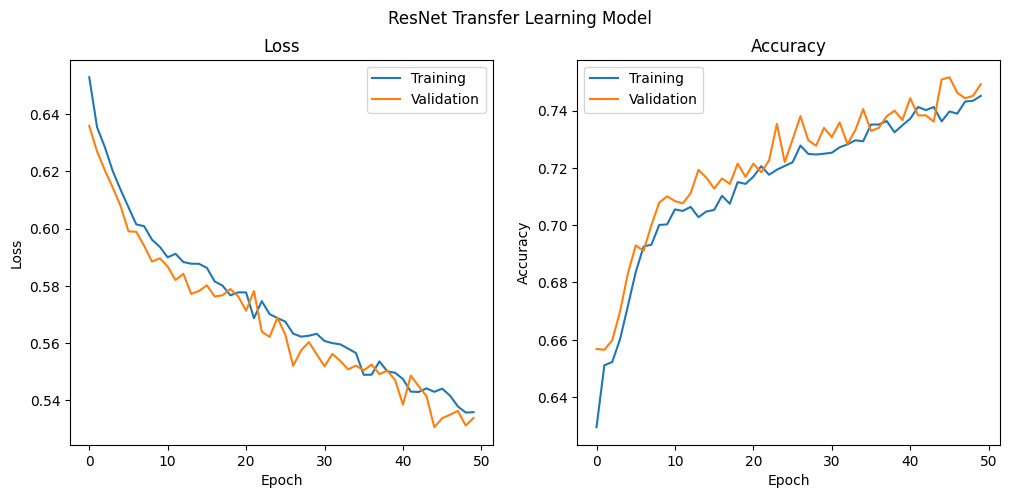

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))

ax1.plot(resnet_history.history['loss'])
ax1.plot(resnet_history.history['val_loss'])
ax1.set_title('Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['Training', 'Validation'])
ax2.plot(resnet_history.history['accuracy'])
ax2.plot(resnet_history.history['val_accuracy'])
ax2.set_title('Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['Training', 'Validation'])
fig.suptitle('ResNet Transfer Learning Model')
plt.show()

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
dense_32 (Dense)             (None, 4, 4, 10)          20490     
_________________________________________________________________
dense_33 (Dense)             (None, 4, 4, 10)          110       
_________________________________________________________________
flatten_11 (Flatten)         (None, 160)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 2)                 322       
Total params: 23,608,634
Trainable params: 20,922
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
train_pred = model.predict(train_set)
train_pred = np.argmax(train_pred,axis=1)
print(classification_report(train_set.labels, train_pred))

              precision    recall  f1-score   support

           0       0.65      0.79      0.72      9583
           1       0.36      0.22      0.27      5137

    accuracy                           0.59     14720
   macro avg       0.51      0.51      0.49     14720
weighted avg       0.55      0.59      0.56     14720



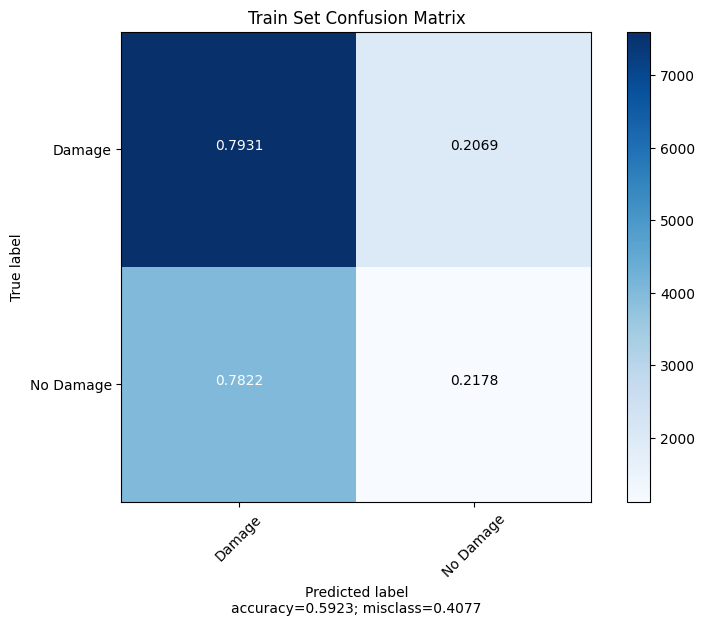

In [ ]:
cm = confusion_matrix(train_set.labels, train_pred)
plot_confusion_matrix(cm, target_names=['Damage', 'No Damage'], title='Train Set Confusion Matrix', cmap='Blues', normalize=True)

In [ ]:
test_pred = model.predict(test_set)
test_pred = np.argmax(test_pred,axis=1)

print(classification_report(test_set.labels, test_pred))

              precision    recall  f1-score   support

           0       0.74      0.93      0.82      3000
           1       0.74      0.39      0.51      1600

    accuracy                           0.74      4600
   macro avg       0.74      0.66      0.67      4600
weighted avg       0.74      0.74      0.72      4600



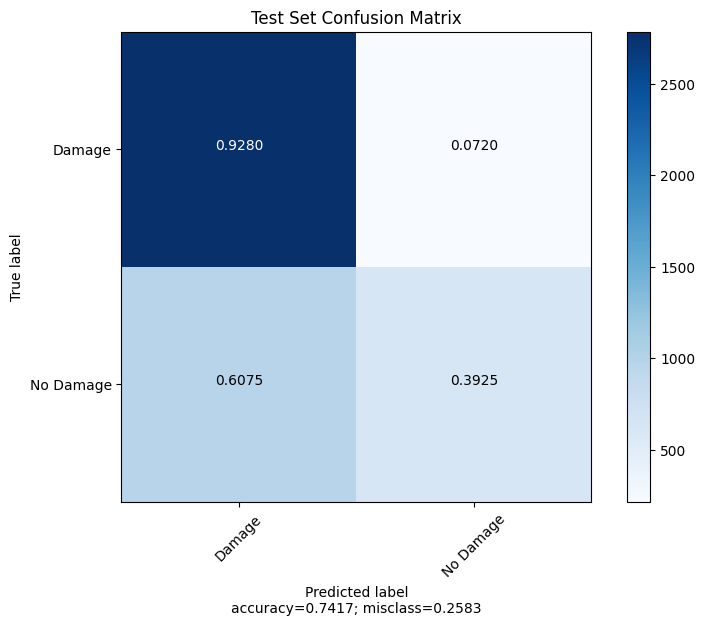

In [ ]:
cm = confusion_matrix(test_set.labels, test_pred)
plot_confusion_matrix(cm, target_names=['Damage', 'No Damage'], title='Test Set Confusion Matrix', cmap='Blues', normalize=True)

In [ ]:
valid_pred = model.predict(valid_set)
valid_pred = np.argmax(valid_pred,axis=1)

print(classification_report(valid_set.labels, valid_pred))

              precision    recall  f1-score   support

           0       0.76      0.92      0.83      2417
           1       0.73      0.44      0.55      1263

    accuracy                           0.75      3680
   macro avg       0.75      0.68      0.69      3680
weighted avg       0.75      0.75      0.73      3680



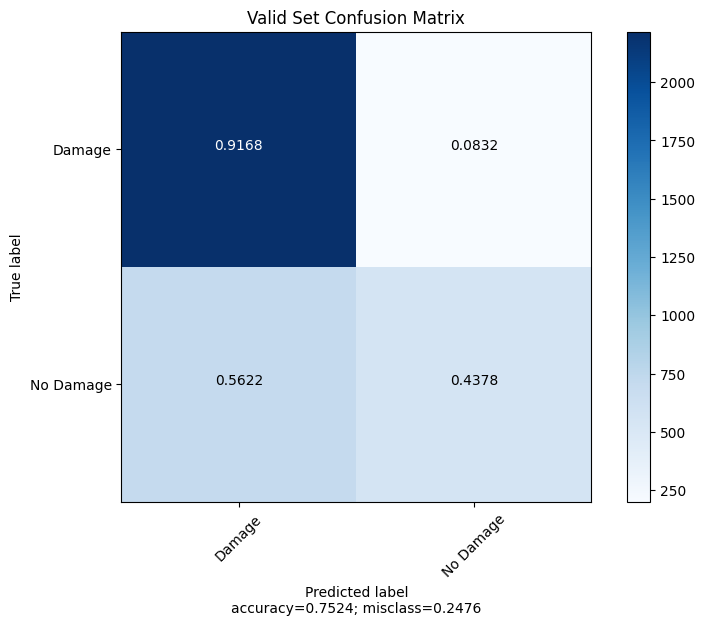

In [ ]:
cm = confusion_matrix(valid_set.labels, valid_pred)
plot_confusion_matrix(cm, target_names=['Damage', 'No Damage'], title='Valid Set Confusion Matrix', cmap='Blues', normalize=True)

In [ ]:
score = model.evaluate(test_set, verbose=1)

46/46 [==============================] - 3s 67ms/step - loss: 0.5226 - accuracy: 0.7417


In [ ]:
# save model to JSON
resnet_model_json = model.to_json()
with open("/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/resnet_model.json", "w") as json_file:
    json_file.write(resnet_model_json)
# save weights to HDF5
model.save_weights("/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/resnet_model_weights.h5")
print("Saved model to disk")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Saved model to disk


In [ ]:
#saving the model and histories
tf.keras.models.save_model(filepath='/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df', model=model)
model.save('/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df')
np.save('/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df/history_resnet.npy', resnet_history.history)
results['model'].append('RESNET')
results['total_param'].append(23608634)
results['time'].append(run_time)
results['score'].append(score[1])

INFO:tensorflow:Assets written to: /content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
results

{'model': ['simple_model', 'VGG16', 'RESNET'],
 'score': [0.6245652437210083, 0.8732608556747437, 0.7417391538619995],
 'time': [876.4248883724213, 3680.210971593857, 3740.5887427330017],
 'total_param': [327832, 14720250, 23608634]}

### *C. Experimenting with Custom CNN*

In [ ]:
model = Sequential()

# input layers
model.add(Conv2D(16, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu', input_shape=(img_height, img_width, 3)))

# block 1
model.add(Conv2D(32, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'))
model.add(Dropout(0.25))

# block 2
model.add(Conv2D(64, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'))
model.add(Dropout(0.25))

# block 3 
model.add(Conv2D(128, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'))

# final block
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='valid', data_format='channels_last'))

# output layer
model.add(Flatten())
model.add(Dense(2, activation='sigmoid'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
ES = EarlyStopping(min_delta=0.0001, patience=5, restore_best_weights=True)
early_stopping = [ES]
start = time.time()

cnn1_history = model.fit(train_set, epochs=50, batch_size=batch_size, verbose=1, validation_data=valid_set, callbacks=early_stopping, steps_per_epoch=train_set.samples//batch_size, validation_steps=valid_set.samples//batch_size)
run_time = time.time() - start

Epoch 1/50
147/147 [==============================] - 74s 502ms/step - loss: 0.6196 - accuracy: 0.6632 - val_loss: 0.6643 - val_accuracy: 0.6858
Epoch 2/50
147/147 [==============================] - 73s 497ms/step - loss: 0.5123 - accuracy: 0.7725 - val_loss: 0.6072 - val_accuracy: 0.7917
Epoch 3/50
147/147 [==============================] - 73s 499ms/step - loss: 0.4250 - accuracy: 0.8282 - val_loss: 0.5174 - val_accuracy: 0.8106
Epoch 4/50
147/147 [==============================] - 73s 496ms/step - loss: 0.3706 - accuracy: 0.8569 - val_loss: 0.3752 - val_accuracy: 0.8547
Epoch 5/50
147/147 [==============================] - 73s 498ms/step - loss: 0.3351 - accuracy: 0.8746 - val_loss: 0.3826 - val_accuracy: 0.8231
Epoch 6/50
147/147 [==============================] - 73s 498ms/step - loss: 0.3160 - accuracy: 0.8806 - val_loss: 0.3687 - val_accuracy: 0.8336
Epoch 7/50
147/147 [==============================] - 73s 497ms/step - loss: 0.2981 - accuracy: 0.8885 - val_loss: 0.2888 - val_ac

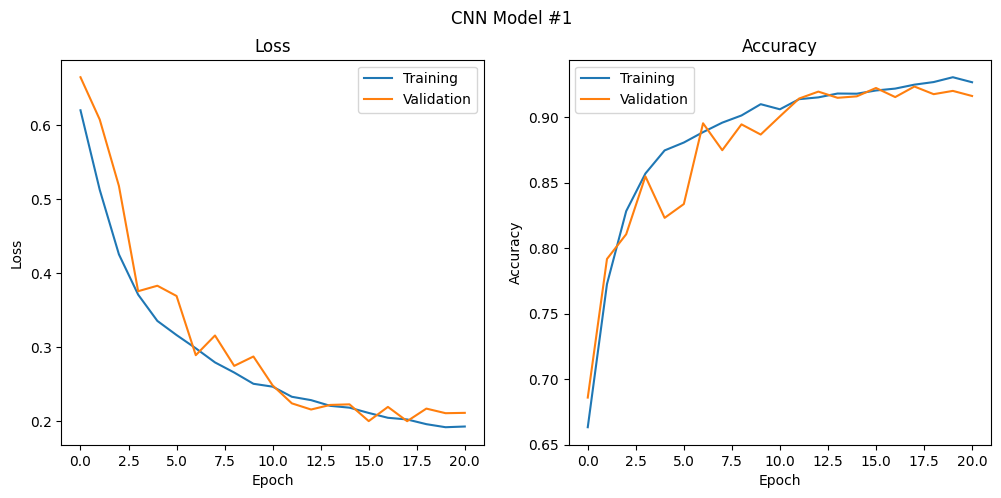

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))

ax1.plot(cnn1_history.history['loss'])
ax1.plot(cnn1_history.history['val_loss'])
ax1.set_title('Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['Training', 'Validation'])
ax2.plot(cnn1_history.history['accuracy'])
ax2.plot(cnn1_history.history['val_accuracy'])
ax2.set_title('Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['Training', 'Validation'])
fig.suptitle('CNN Model #1')
plt.show()

In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 64, 64, 16)        448       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
dropout_16 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_17 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
dense_35 (Dense)             (None, 8, 8, 64)        

In [ ]:
train_pred = model.predict(train_set)
train_pred = np.argmax(train_pred,axis=1)

In [ ]:
print(classification_report(train_pred, train_set.labels, ))

              precision    recall  f1-score   support

           0       0.67      0.65      0.66      9771
           1       0.34      0.35      0.35      4949

    accuracy                           0.55     14720
   macro avg       0.50      0.50      0.50     14720
weighted avg       0.56      0.55      0.56     14720



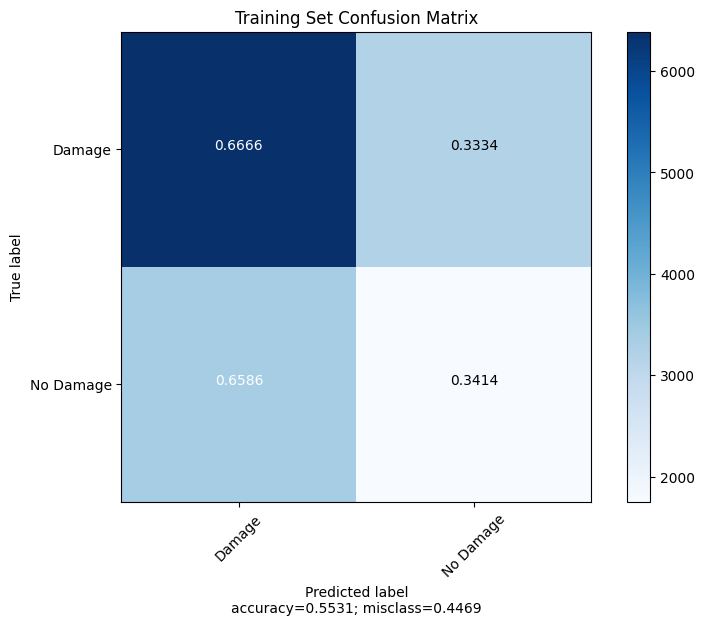

In [ ]:
cm = confusion_matrix(train_set.labels, train_pred)
plot_confusion_matrix(cm, target_names=['Damage', 'No Damage'], title='Training Set Confusion Matrix', cmap='Blues', normalize=True)

In [ ]:
test_pred = model.predict(test_set)
test_pred = np.argmax(test_pred,axis=1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_set.labels, test_pred))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      3000
           1       0.94      0.78      0.85      1600

    accuracy                           0.91      4600
   macro avg       0.92      0.88      0.89      4600
weighted avg       0.91      0.91      0.90      4600



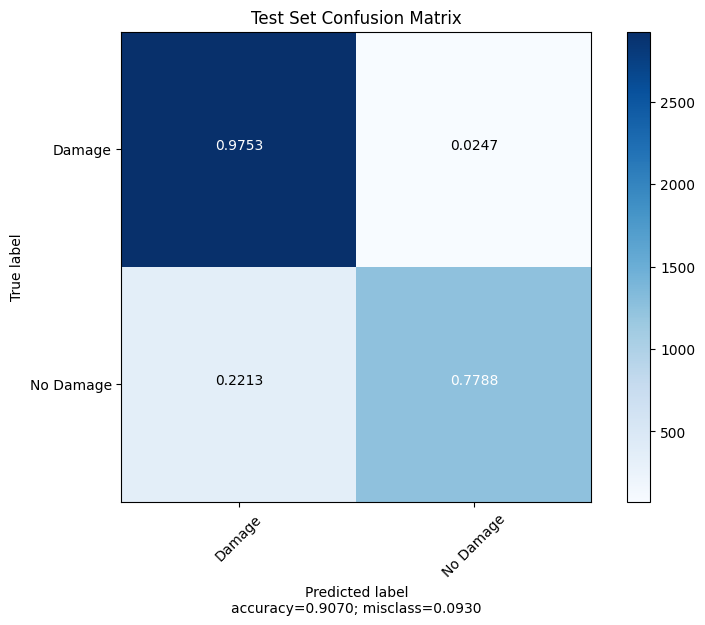

In [ ]:
cm = confusion_matrix(test_set.labels, test_pred)
plot_confusion_matrix(cm, target_names=['Damage', 'No Damage'], title='Test Set Confusion Matrix', cmap='Blues', normalize=True)

In [ ]:
valid_pred = model.predict(valid_set)
valid_pred = np.argmax(valid_pred,axis=1)
print(classification_report(valid_set.labels, valid_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      2417
           1       0.91      0.86      0.89      1263

    accuracy                           0.92      3680
   macro avg       0.92      0.91      0.92      3680
weighted avg       0.92      0.92      0.92      3680



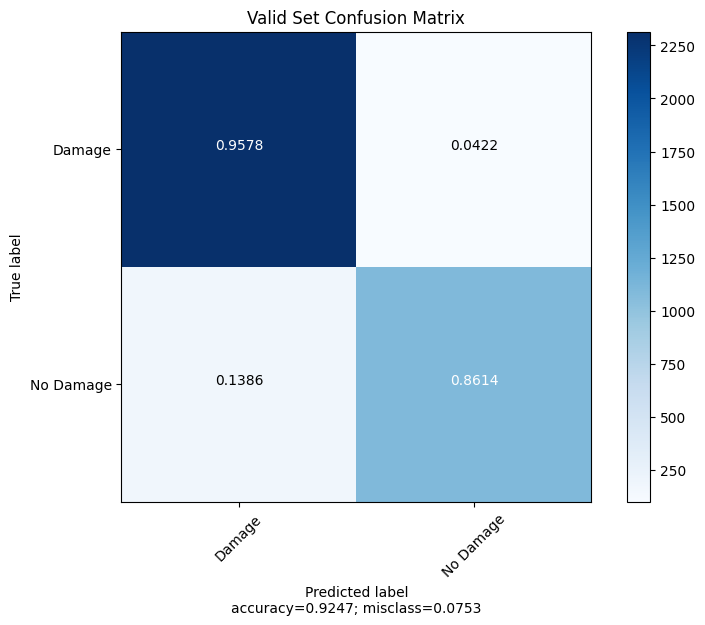

In [ ]:
cm = confusion_matrix(valid_set.labels, valid_pred)
plot_confusion_matrix(cm, target_names=['Damage', 'No Damage'], title='Valid Set Confusion Matrix', cmap='Blues', normalize=True)

In [ ]:
score = model.evaluate(test_set, verbose=1)

46/46 [==============================] - 3s 57ms/step - loss: 0.2222 - accuracy: 0.9070


In [ ]:
# save model to JSON
cnn1_model_json = model.to_json()
with open("/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/cnn1_model.json", "w") as json_file:
    json_file.write(cnn1_model_json)
# save weights to HDF5
model.save_weights("/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/cnn1_model_weights.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
#saving the model and histories
tf.keras.models.save_model(filepath='/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df', model=model)
model.save('/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df')
np.save('/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df/history_cnn1.npy', cnn1_history.history)
results['model'].append('CNN1')
results['total_param'].append(108002)
results['time'].append(run_time)
results['score'].append(score[1])

INFO:tensorflow:Assets written to: /content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df/assets


*D. Custom Model 2*

In [ ]:
ES3 = EarlyStopping(min_delta=0.0001, patience=5)
early_stopping3 = [ES3]

model = Sequential()

# input layers
model.add(Conv2D(128, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.5))

# block 1
model.add(Conv2D(256, kernel_size=(3,3), strides=(2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.5))

model.add(Conv2D(512, kernel_size=(3,3), strides=(2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.5))

model.add(Conv2D(1024, kernel_size=(3,3), strides=(2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.5))

model.add(Conv2D(2048, kernel_size=(3,3), strides=(2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.5))

# final block
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))

# output layer
model.add(Flatten())
model.add(Dense(2, activation='sigmoid'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
start = time.time()
cnn2_history = model.fit(train_set, batch_size=100, epochs=50, shuffle=True, validation_data=valid_set, callbacks=early_stopping3, steps_per_epoch=train_set.samples//batch_size, validation_steps=valid_set.samples//batch_size)
run_time = time.time() - start

Epoch 1/50
147/147 [==============================] - 75s 507ms/step - loss: 0.7710 - accuracy: 0.5947 - val_loss: 0.6420 - val_accuracy: 0.6575
Epoch 2/50
147/147 [==============================] - 73s 500ms/step - loss: 0.6904 - accuracy: 0.6236 - val_loss: 0.6506 - val_accuracy: 0.6575
Epoch 3/50
147/147 [==============================] - 74s 503ms/step - loss: 0.6025 - accuracy: 0.6867 - val_loss: 0.6864 - val_accuracy: 0.6581
Epoch 4/50
147/147 [==============================] - 73s 498ms/step - loss: 0.5361 - accuracy: 0.7500 - val_loss: 0.5832 - val_accuracy: 0.6933
Epoch 5/50
147/147 [==============================] - 74s 502ms/step - loss: 0.4720 - accuracy: 0.7986 - val_loss: 0.4294 - val_accuracy: 0.8044
Epoch 6/50
147/147 [==============================] - 74s 501ms/step - loss: 0.4008 - accuracy: 0.8360 - val_loss: 0.4706 - val_accuracy: 0.7903
Epoch 7/50
147/147 [==============================] - 73s 500ms/step - loss: 0.3398 - accuracy: 0.8654 - val_loss: 0.4787 - val_ac

In [ ]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 64, 64, 128)       3584      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 16, 16, 256)       295168    
_________________________________________________________________
batch_normalization_12 (Batc (None, 16, 16, 256)       1024      
_________________________________________________________________
activation_12 (Activation)   (None, 16, 16, 256)       0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 8, 8, 256)       

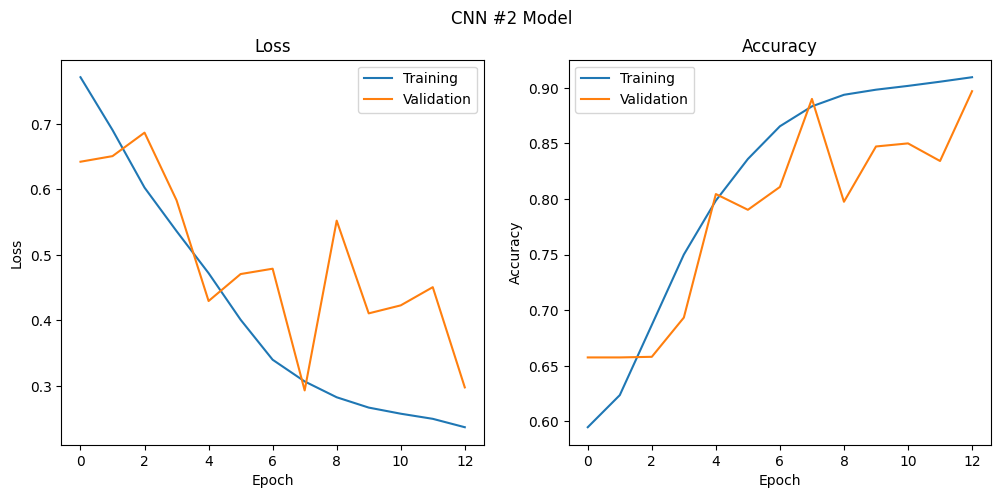

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))

ax1.plot(cnn2_history.history['loss'])
ax1.plot(cnn2_history.history['val_loss'])
ax1.set_title('Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['Training', 'Validation'])
ax2.plot(cnn2_history.history['accuracy'])
ax2.plot(cnn2_history.history['val_accuracy'])
ax2.set_title('Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['Training', 'Validation'])
fig.suptitle('CNN #2 Model')
plt.show()

In [ ]:
train_pred = model.predict(train_set)
train_pred = np.argmax(train_pred,axis=1)

In [ ]:
print(classification_report(train_set.labels, train_pred))

              precision    recall  f1-score   support

           0       0.64      0.59      0.61      9583
           1       0.34      0.39      0.36      5137

    accuracy                           0.52     14720
   macro avg       0.49      0.49      0.49     14720
weighted avg       0.54      0.52      0.53     14720



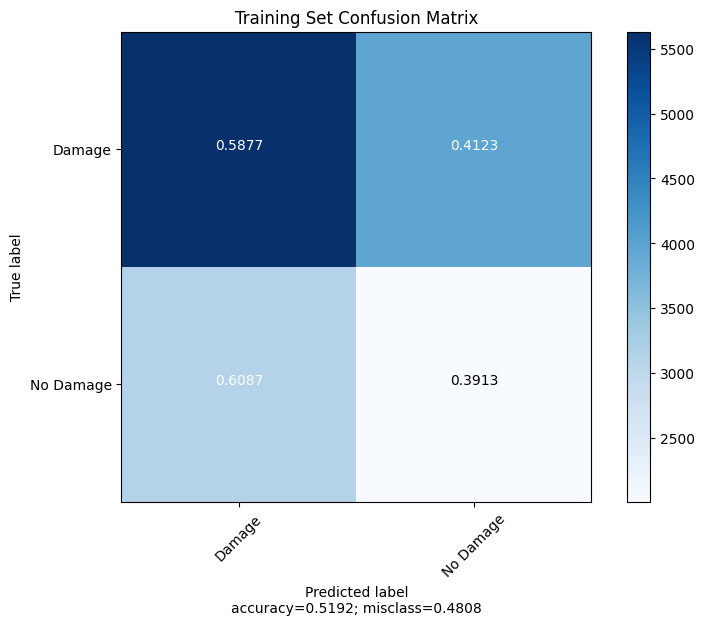

In [ ]:
cm = confusion_matrix(train_set.labels, train_pred)
plot_confusion_matrix(cm, target_names=['Damage', 'No Damage'], title='Training Set Confusion Matrix', cmap='Blues', normalize=True)

In [ ]:
test_pred = model.predict(test_set)
test_pred = np.argmax(test_pred,axis=1)

In [ ]:
print(classification_report(test_set.labels, test_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      3000
           1       0.85      0.86      0.85      1600

    accuracy                           0.90      4600
   macro avg       0.89      0.89      0.89      4600
weighted avg       0.90      0.90      0.90      4600



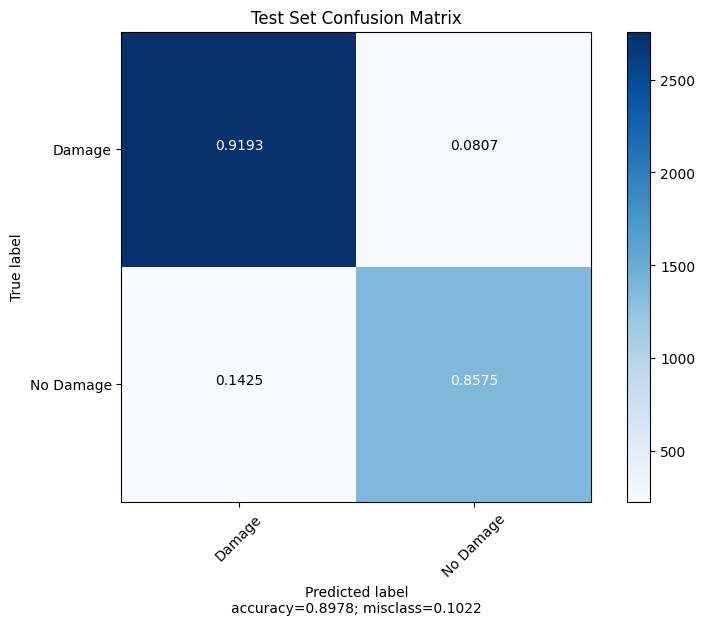

In [ ]:
cm = confusion_matrix(test_set.labels, test_pred)
plot_confusion_matrix(cm, target_names=['Damage', 'No Damage'], title='Test Set Confusion Matrix', cmap='Blues', normalize=True)

In [ ]:
valid_pred = model.predict(valid_set)
valid_pred = np.argmax(valid_pred,axis=1)
print(classification_report(valid_set.labels, valid_pred))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      2417
           1       0.81      0.91      0.86      1263

    accuracy                           0.89      3680
   macro avg       0.88      0.90      0.89      3680
weighted avg       0.90      0.89      0.90      3680



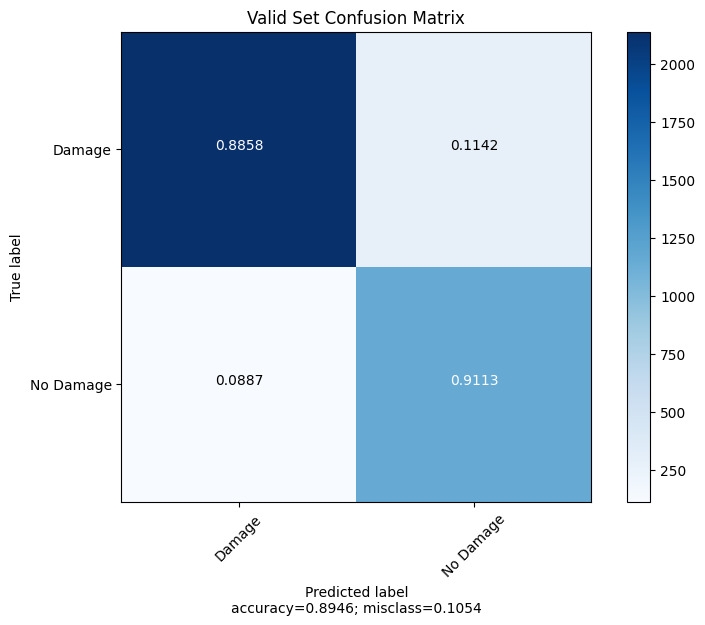

In [ ]:
cm = confusion_matrix(valid_set.labels, valid_pred)
plot_confusion_matrix(cm, target_names=['Damage', 'No Damage'], title='Valid Set Confusion Matrix', cmap='Blues', normalize=True)

In [ ]:
# save model to JSON
cnn2_model_json = model.to_json()
with open("/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/cnn2_model.json", "w") as json_file:
    json_file.write(cnn2_model_json)
# save weights to HDF5
model.save_weights("/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/cnn2_model_weights.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
score = model.evaluate(test_set)

46/46 [==============================] - 3s 58ms/step - loss: 0.2586 - accuracy: 0.8978


In [ ]:
#saving the model and histories
tf.keras.models.save_model(filepath='/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df', model=model)
model.save('/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df')
np.save('/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df/history_cnn2.npy', cnn2_history.history)
results['model'].append('CNN2')
results['total_param'].append(25353358)
results['time'].append(run_time)
results['score'].append(score[1])

INFO:tensorflow:Assets written to: /content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df/assets


In [ ]:
results

{'model': ['simple_model', 'VGG16', 'RESNET', 'CNN1', 'CNN2'],
 'score': [0.6245652437210083,
  0.8732608556747437,
  0.7417391538619995,
  0.9069564938545227,
  0.897826075553894],
 'time': [876.4248883724213,
  3680.210971593857,
  3740.5887427330017,
  1531.6678936481476,
  957.4528160095215],
 'total_param': [327832, 14720250, 23608634, 108002, 25353358]}

E. AlexNet Architecture

In [ ]:
model = Sequential()

model.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(2,2), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1000, activation='relu'))

model.add(Dense(2, activation='sigmoid'))

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy', 'Recall'])

In [ ]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 30, 30, 96)        34944     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 14, 14, 96)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 7, 7, 256)         614656    
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 3, 3, 256)         0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 3, 3, 384)         885120    
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 3, 3, 384)         1327488   
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 3, 3, 256)       

In [ ]:
ES = EarlyStopping(min_delta=0.0001, patience=5)
early_stopping = [ES]

In [ ]:
start = time.time()
an_history = model.fit(train_set, batch_size=batch_size, epochs=50, validation_data=valid_set, verbose=1, callbacks=early_stopping, steps_per_epoch=train_set.samples//batch_size, validation_steps=valid_set.samples//batch_size)
run_time = time.time() - start

Epoch 1/50
147/147 [==============================] - 75s 505ms/step - loss: 0.6555 - accuracy: 0.6502 - recall: 0.6525 - val_loss: 0.6350 - val_accuracy: 0.6575 - val_recall: 0.6575
Epoch 2/50
147/147 [==============================] - 73s 497ms/step - loss: 0.5702 - accuracy: 0.6947 - recall: 0.6966 - val_loss: 0.4775 - val_accuracy: 0.8206 - val_recall: 0.8208
Epoch 3/50
147/147 [==============================] - 73s 498ms/step - loss: 0.4416 - accuracy: 0.8267 - recall: 0.8300 - val_loss: 0.4306 - val_accuracy: 0.8350 - val_recall: 0.8353
Epoch 4/50
147/147 [==============================] - 73s 498ms/step - loss: 0.4156 - accuracy: 0.8379 - recall: 0.8416 - val_loss: 0.4005 - val_accuracy: 0.8483 - val_recall: 0.8489
Epoch 5/50
147/147 [==============================] - 73s 497ms/step - loss: 0.4060 - accuracy: 0.8446 - recall: 0.8473 - val_loss: 0.4170 - val_accuracy: 0.8372 - val_recall: 0.8378
Epoch 6/50
147/147 [==============================] - 73s 497ms/step - loss: 0.3917 -

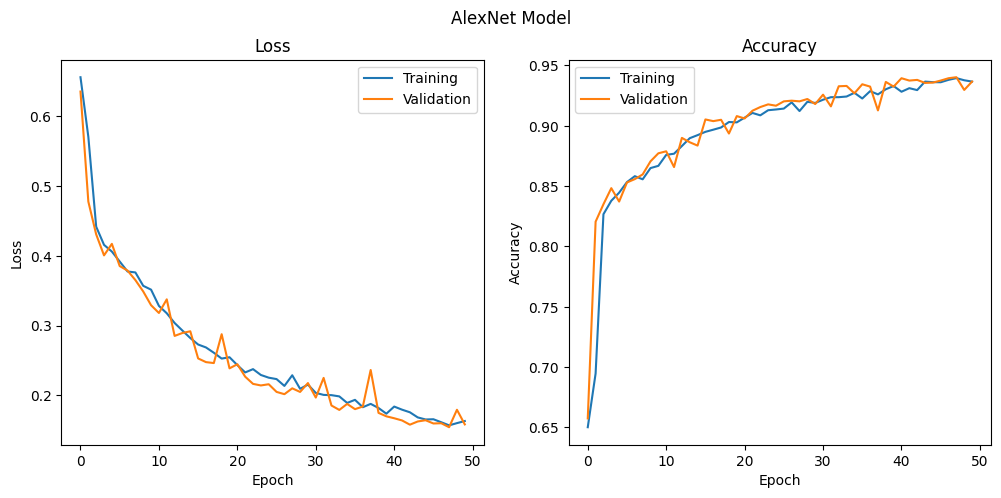

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))

ax1.plot(an_history.history['loss'])
ax1.plot(an_history.history['val_loss'])
ax1.set_title('Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['Training', 'Validation'])
ax2.plot(an_history.history['accuracy'])
ax2.plot(an_history.history['val_accuracy'])
ax2.set_title('Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['Training', 'Validation'])
fig.suptitle('AlexNet Model')
plt.show()

In [ ]:
train_pred = model.predict(train_set)
train_pred = np.argmax(train_pred,axis=1)

In [ ]:
print(classification_report(train_set.labels, train_pred))

              precision    recall  f1-score   support

           0       0.65      0.68      0.67      9583
           1       0.35      0.31      0.33      5137

    accuracy                           0.55     14720
   macro avg       0.50      0.50      0.50     14720
weighted avg       0.54      0.55      0.55     14720



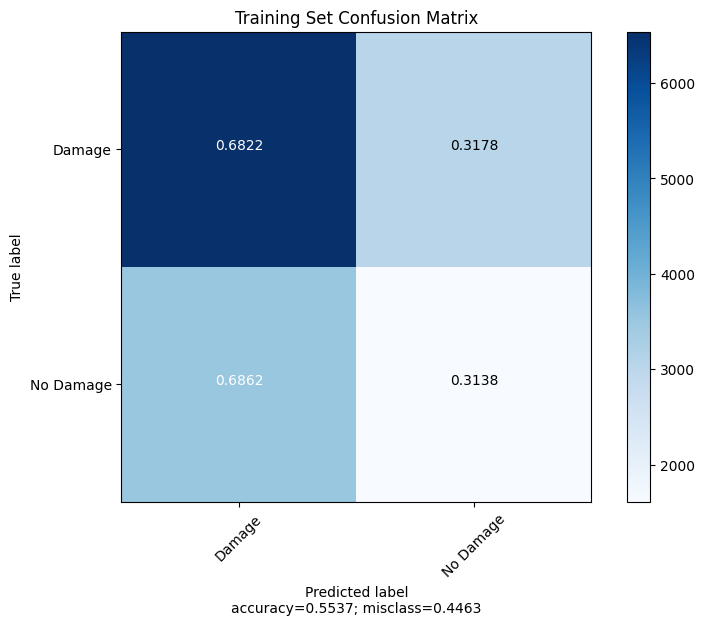

In [ ]:
cm = confusion_matrix(train_set.labels, train_pred)
plot_confusion_matrix(cm, target_names=['Damage', 'No Damage'], title='Training Set Confusion Matrix', cmap='Blues', normalize=True)

In [ ]:
test_pred = model.predict(test_set)
test_pred = np.argmax(test_pred,axis=1)

In [ ]:
print(classification_report(test_set.labels, test_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      3000
           1       0.96      0.81      0.88      1600

    accuracy                           0.92      4600
   macro avg       0.93      0.90      0.91      4600
weighted avg       0.93      0.92      0.92      4600



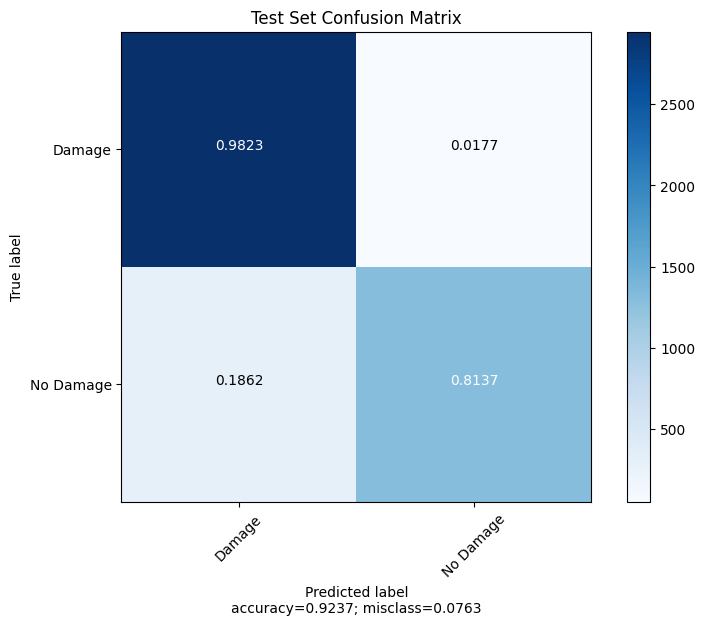

In [ ]:
cm = confusion_matrix(test_set.labels, test_pred)
plot_confusion_matrix(cm, target_names=['Damage', 'No Damage'], title='Test Set Confusion Matrix', cmap='Blues', normalize=True)

In [ ]:
valid_pred = model.predict(valid_set)
valid_pred = np.argmax(valid_pred, axis=1)
print(classification_report(valid_set.labels, valid_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      2417
           1       0.96      0.86      0.91      1263

    accuracy                           0.94      3680
   macro avg       0.94      0.92      0.93      3680
weighted avg       0.94      0.94      0.94      3680



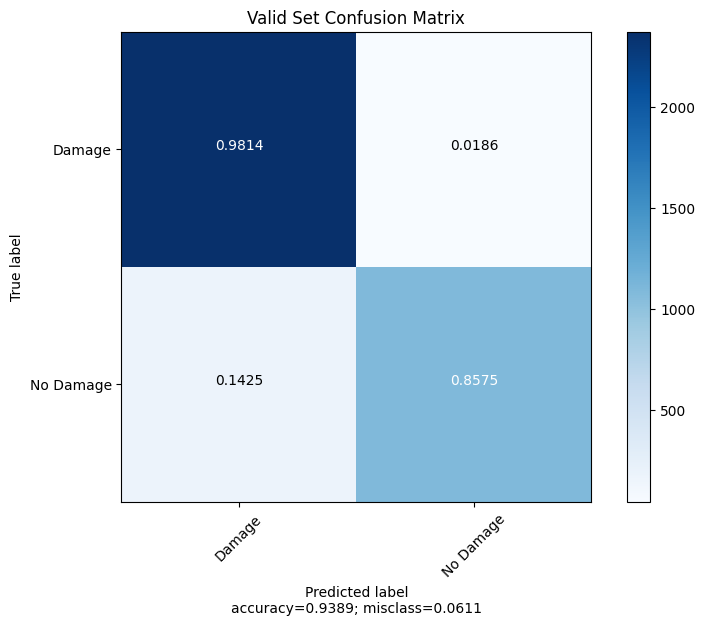

In [ ]:
cm = confusion_matrix(valid_set.labels, valid_pred)
plot_confusion_matrix(cm, target_names=['Damage', 'No Damage'], title='Valid Set Confusion Matrix', cmap='Blues', normalize=True)

In [ ]:
score = model.evaluate(test_set)

46/46 [==============================] - 3s 58ms/step - loss: 0.1936 - accuracy: 0.9237 - recall: 0.9267


In [ ]:
# save model to JSON
alex_model_json = model.to_json()
with open("/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/alex_model.json", "w") as json_file:
    json_file.write(alex_model_json)
# save weights to HDF5
model.save_weights("/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/alex_model_weights.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
#saving the model and histories
tf.keras.models.save_model(filepath='/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df', model=model)
model.save('/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df')
np.save('/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df/history_an.npy', an_history.history)
results['model'].append('AlexNet')
results['total_param'].append(28825914)
results['time'].append(run_time)
results['score'].append(score[1])

INFO:tensorflow:Assets written to: /content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df/assets


In [ ]:
results

{'model': ['simple_model', 'VGG16', 'RESNET', 'CNN1', 'CNN2', 'AlexNet'],
 'score': [0.6245652437210083,
  0.8732608556747437,
  0.7417391538619995,
  0.9069564938545227,
  0.897826075553894,
  0.9236956238746643],
 'time': [876.4248883724213,
  3680.210971593857,
  3740.5887427330017,
  1531.6678936481476,
  957.4528160095215,
  3664.4199018478394],
 'total_param': [327832, 14720250, 23608634, 108002, 25353358, 28825914]}

In [ ]:
np.save('/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df/results.npy', results)

## CNN Model 2 with class balanced weights

In [ ]:
ES3 = EarlyStopping(min_delta=0.0001, patience=5)
early_stopping3 = [ES3]

model = Sequential()

# input layers
model.add(Conv2D(128, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.5))

# block 1
model.add(Conv2D(256, kernel_size=(3,3), strides=(2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.5))

model.add(Conv2D(512, kernel_size=(3,3), strides=(2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.5))

model.add(Conv2D(1024, kernel_size=(3,3), strides=(2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.5))

model.add(Conv2D(2048, kernel_size=(3,3), strides=(2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.5))

# final block
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))

# output layer
model.add(Flatten())
model.add(Dense(2, activation='sigmoid'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', 'Recall'])

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', np.unique(train_set.classes), train_set.classes)

train_class_weights = dict(enumerate(class_weights))

In [ ]:
start = time.time()
cnnweighted_history = model.fit(train_set, batch_size=batch_size, epochs=50, validation_data=valid_set, callbacks=early_stopping3, steps_per_epoch=train_set.samples//batch_size, validation_steps=valid_set.samples//batch_size, class_weight=train_class_weights)
run_time = time.time() - start

Epoch 1/50
147/147 [==============================] - 76s 506ms/step - loss: 0.8073 - accuracy: 0.4869 - recall: 0.4902 - val_loss: 0.7247 - val_accuracy: 0.3425 - val_recall: 1.0000
Epoch 2/50
147/147 [==============================] - 73s 500ms/step - loss: 0.7238 - accuracy: 0.5380 - recall: 0.5174 - val_loss: 0.6368 - val_accuracy: 0.6575 - val_recall: 0.6575
Epoch 3/50
147/147 [==============================] - 73s 500ms/step - loss: 0.6308 - accuracy: 0.6485 - recall: 0.5925 - val_loss: 0.6763 - val_accuracy: 0.6572 - val_recall: 0.6556
Epoch 4/50
147/147 [==============================] - 73s 498ms/step - loss: 0.5638 - accuracy: 0.7276 - recall: 0.6707 - val_loss: 0.5186 - val_accuracy: 0.7278 - val_recall: 0.6408
Epoch 5/50
147/147 [==============================] - 74s 502ms/step - loss: 0.4975 - accuracy: 0.7788 - recall: 0.7306 - val_loss: 0.4574 - val_accuracy: 0.7850 - val_recall: 0.7319
Epoch 6/50
147/147 [==============================] - 73s 499ms/step - loss: 0.4019 -

In [ ]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 64, 64, 128)       3584      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 16, 16, 256)       295168    
_________________________________________________________________
batch_normalization_17 (Batc (None, 16, 16, 256)       1024      
_________________________________________________________________
activation_17 (Activation)   (None, 16, 16, 256)       0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 8, 8, 256)       

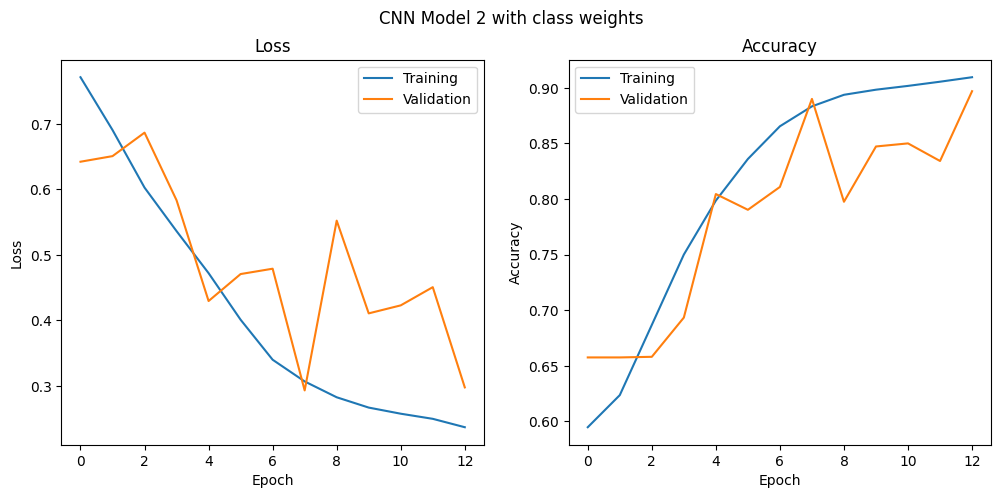

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))

ax1.plot(cnn2_history.history['loss'])
ax1.plot(cnn2_history.history['val_loss'])
ax1.set_title('Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['Training', 'Validation'])
ax2.plot(cnn2_history.history['accuracy'])
ax2.plot(cnn2_history.history['val_accuracy'])
ax2.set_title('Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['Training', 'Validation'])
fig.suptitle('CNN Model 2 with class weights')
plt.show()

In [ ]:
train_pred = model.predict(train_set)
train_pred = np.argmax(train_pred,axis=1)
print(classification_report(train_set.labels, train_pred))

              precision    recall  f1-score   support

           0       0.66      0.46      0.54      9583
           1       0.35      0.55      0.43      5137

    accuracy                           0.49     14720
   macro avg       0.50      0.50      0.48     14720
weighted avg       0.55      0.49      0.50     14720



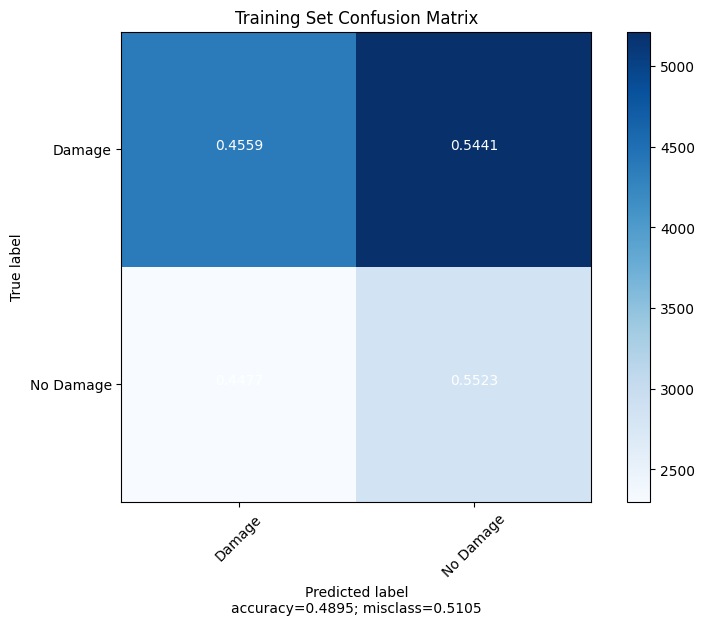

In [ ]:
cm = confusion_matrix(train_set.labels, train_pred)
plot_confusion_matrix(cm, target_names=['Damage', 'No Damage'], title='Training Set Confusion Matrix', cmap='Blues', normalize=True)

In [ ]:
test_pred = model.predict(test_set)
test_pred = np.argmax(test_pred,axis=1)
print(classification_report(test_set.labels, test_pred))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80      3000
           1       0.62      0.99      0.76      1600

    accuracy                           0.78      4600
   macro avg       0.81      0.83      0.78      4600
weighted avg       0.86      0.78      0.79      4600



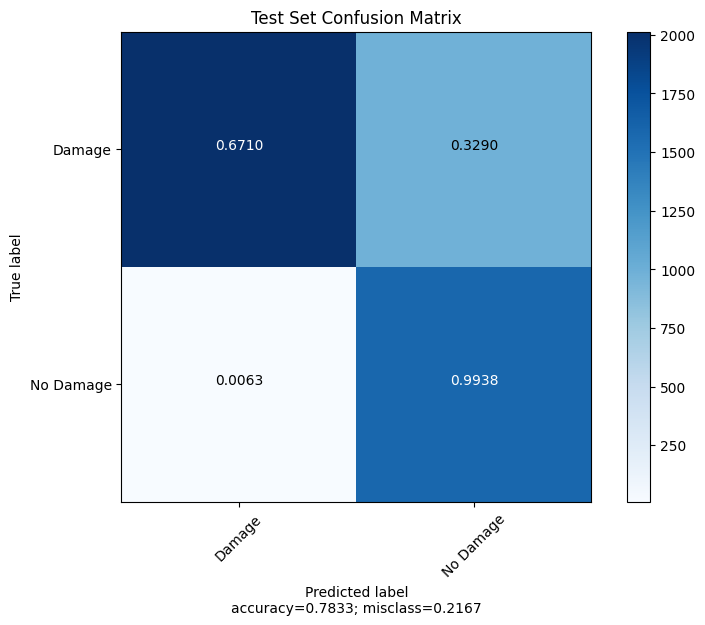

In [ ]:
cm = confusion_matrix(test_set.labels, test_pred)
plot_confusion_matrix(cm, target_names=['Damage', 'No Damage'], title='Test Set Confusion Matrix', cmap='Blues', normalize=True)

In [ ]:
valid_pred = model.predict(valid_set)
valid_pred = np.argmax(valid_pred,axis=1)
print(classification_report(valid_set.labels, valid_pred))

              precision    recall  f1-score   support

           0       0.98      0.68      0.81      2417
           1       0.62      0.98      0.76      1263

    accuracy                           0.79      3680
   macro avg       0.80      0.83      0.78      3680
weighted avg       0.86      0.79      0.79      3680



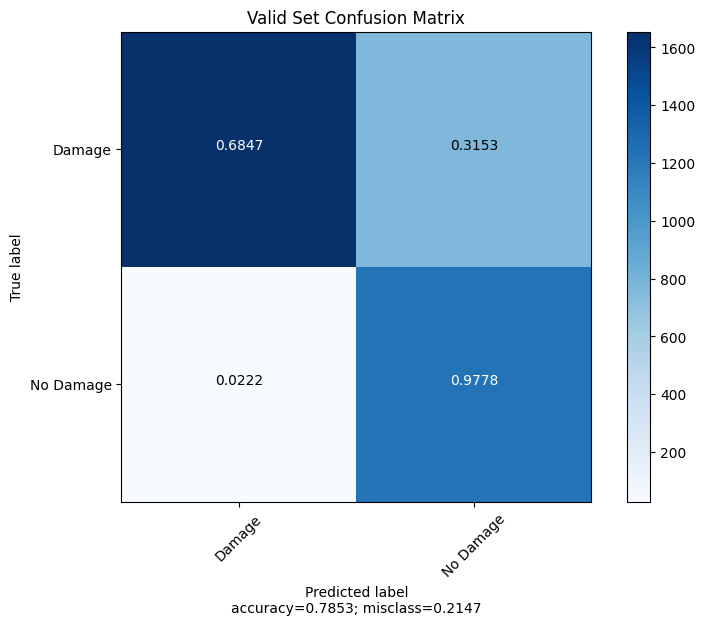

In [ ]:
cm = confusion_matrix(valid_set.labels, valid_pred)
plot_confusion_matrix(cm, target_names=['Damage', 'No Damage'], title='Valid Set Confusion Matrix', cmap='Blues', normalize=True)

In [ ]:
score = model.evaluate(test_set)

46/46 [==============================] - 3s 58ms/step - loss: 0.6099 - accuracy: 0.7833 - recall: 0.7337


In [ ]:
# save model to JSON
cnnweighted_json = model.to_json()
with open("/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/cnnweighted_model.json", "w") as json_file:
    json_file.write(cnnweighted_json)
# save weights to HDF5
model.save_weights("/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/cnnweighted_model_weights.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
#saving the model and histories
tf.keras.models.save_model(filepath='/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df', model=model)
model.save('/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df')
np.save('/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df/history_cnnweights.npy', cnnweighted_history.history)
results['model'].append('CNN w/ Weights')
results['total_param'].append(25353346)
results['time'].append(run_time)
results['score'].append(score[1])

INFO:tensorflow:Assets written to: /content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df/assets


In [ ]:
results

{'model': ['simple_model',
  'VGG16',
  'RESNET',
  'CNN1',
  'CNN2',
  'AlexNet',
  'CNN w/ Weights'],
 'score': [0.6245652437210083,
  0.8732608556747437,
  0.7417391538619995,
  0.9069564938545227,
  0.897826075553894,
  0.9236956238746643,
  0.7832608819007874],
 'time': [876.4248883724213,
  3680.210971593857,
  3740.5887427330017,
  1531.6678936481476,
  957.4528160095215,
  3664.4199018478394,
  1251.3907644748688],
 'total_param': [327832,
  14720250,
  23608634,
  108002,
  25353358,
  28825914,
  25353346]}

##AlexNet Model w/ Class Weights

In [ ]:
model = Sequential()

model.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(2,2), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1000, activation='relu'))

model.add(Dense(2, activation='sigmoid'))

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy', 'Recall'])

In [ ]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 30, 30, 96)        34944     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 14, 14, 96)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 7, 7, 256)         614656    
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 3, 3, 256)         0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 3, 3, 384)         885120    
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 3, 3, 384)         1327488   
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 3, 3, 256)       

In [ ]:
ES = EarlyStopping(min_delta=0.00001, patience=5)
early_stopping = [ES]

In [ ]:
start = time.time()
an_weights_history = model.fit(train_set, batch_size=batch_size, epochs=100, validation_data=valid_set, verbose=1, callbacks=early_stopping, steps_per_epoch=train_set.samples//batch_size, validation_steps=valid_set.samples//batch_size, class_weight=train_class_weights)
run_time = time.time() - start

Epoch 1/100
147/147 [==============================] - 75s 505ms/step - loss: 0.6837 - accuracy: 0.3934 - recall: 0.4194 - val_loss: 0.6437 - val_accuracy: 0.6450 - val_recall: 0.6525
Epoch 2/100
147/147 [==============================] - 73s 496ms/step - loss: 0.5043 - accuracy: 0.7877 - recall: 0.7916 - val_loss: 0.4267 - val_accuracy: 0.8375 - val_recall: 0.8400
Epoch 3/100
147/147 [==============================] - 73s 499ms/step - loss: 0.4560 - accuracy: 0.8268 - recall: 0.8308 - val_loss: 0.4222 - val_accuracy: 0.8408 - val_recall: 0.8433
Epoch 4/100
147/147 [==============================] - 73s 497ms/step - loss: 0.4393 - accuracy: 0.8356 - recall: 0.8378 - val_loss: 0.4069 - val_accuracy: 0.8469 - val_recall: 0.8478
Epoch 5/100
147/147 [==============================] - 73s 498ms/step - loss: 0.4207 - accuracy: 0.8456 - recall: 0.8462 - val_loss: 0.3918 - val_accuracy: 0.8525 - val_recall: 0.8528
Epoch 6/100
147/147 [==============================] - 73s 496ms/step - loss: 0.

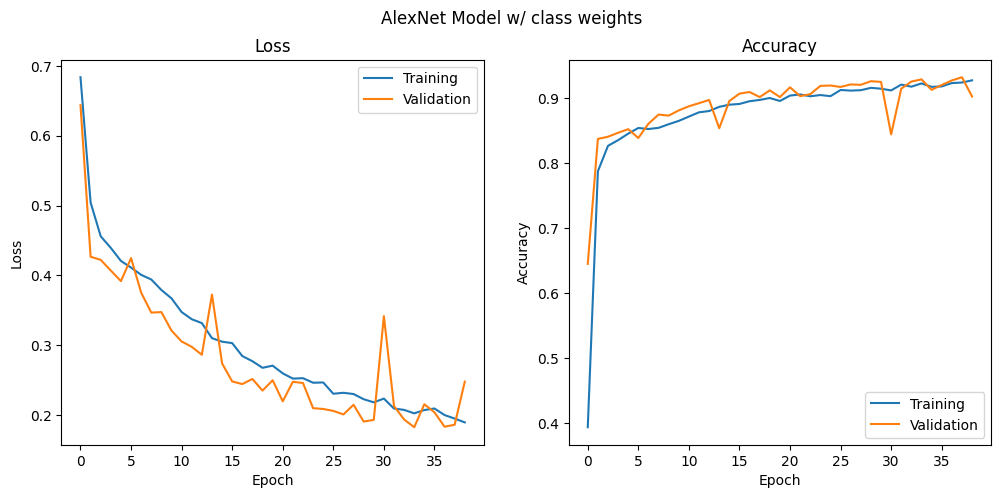

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))

ax1.plot(an_weights_history.history['loss'])
ax1.plot(an_weights_history.history['val_loss'])
ax1.set_title('Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['Training', 'Validation'])
ax2.plot(an_weights_history.history['accuracy'])
ax2.plot(an_weights_history.history['val_accuracy'])
ax2.set_title('Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['Training', 'Validation'])
fig.suptitle('AlexNet Model w/ class weights')
plt.show()

In [ ]:
train_pred = model.predict(train_set)
train_pred = np.argmax(train_pred,axis=1)
print(classification_report(train_set.labels, train_pred))

              precision    recall  f1-score   support

           0       0.66      0.58      0.62      9583
           1       0.36      0.43      0.39      5137

    accuracy                           0.53     14720
   macro avg       0.51      0.51      0.51     14720
weighted avg       0.55      0.53      0.54     14720



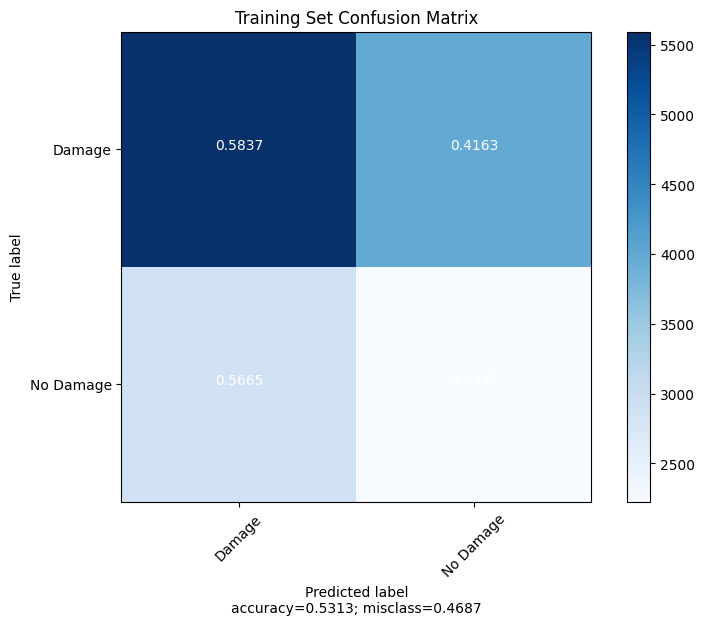

In [ ]:
cm = confusion_matrix(train_set.labels, train_pred)
plot_confusion_matrix(cm, target_names=['Damage', 'No Damage'], title='Training Set Confusion Matrix', cmap='Blues', normalize=True)

In [ ]:
test_pred = model.predict(test_set)
test_pred = np.argmax(test_pred,axis=1)

In [ ]:
print(classification_report(test_set.labels, test_pred))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92      3000
           1       0.82      0.93      0.87      1600

    accuracy                           0.90      4600
   macro avg       0.89      0.91      0.90      4600
weighted avg       0.91      0.90      0.91      4600



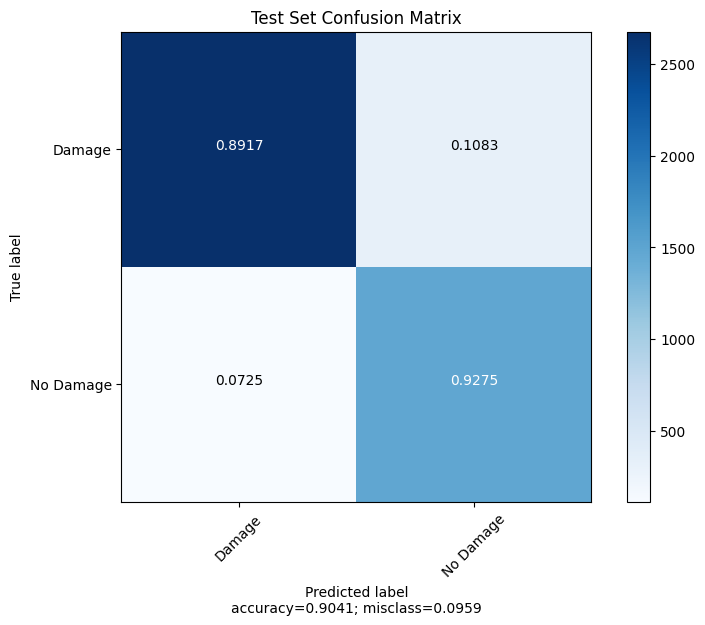

In [ ]:
cm = confusion_matrix(test_set.labels, test_pred)
plot_confusion_matrix(cm, target_names=['Damage', 'No Damage'], title='Test Set Confusion Matrix', cmap='Blues', normalize=True)

In [ ]:
valid_pred = model.predict(valid_set)
valid_pred = np.argmax(valid_pred, axis=1)
print(classification_report(valid_set.labels, valid_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92      2417
           1       0.80      0.95      0.87      1263

    accuracy                           0.90      3680
   macro avg       0.89      0.91      0.89      3680
weighted avg       0.91      0.90      0.90      3680



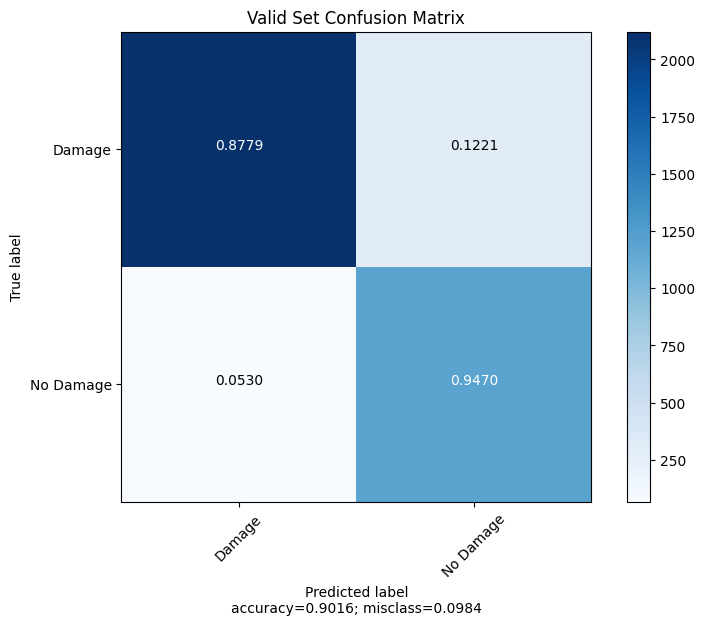

In [ ]:
cm = confusion_matrix(valid_set.labels, valid_pred)
plot_confusion_matrix(cm, target_names=['Damage', 'No Damage'], title='Valid Set Confusion Matrix', cmap='Blues', normalize=True)

In [ ]:
score = model.evaluate(test_set, verbose=1)

46/46 [==============================] - 3s 58ms/step - loss: 0.2367 - accuracy: 0.9041 - recall: 0.9085


In [ ]:
# save model to JSON
alex_weights_json = model.to_json()
with open("/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/an_weights_model.json", "w") as json_file:
    json_file.write(alex_weights_json)
# save weights to HDF5
model.save_weights("/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/an_weighted_weights.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
#saving the model and histories
tf.keras.models.save_model(filepath='/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df', model=model)
model.save('/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df')
np.save('/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df/history_an_.npy', an_weights_history.history)
results['model'].append('AlexNet w/ Weights')
results['total_param'].append(25680186)
results['time'].append(run_time)
results['score'].append(score[1])

INFO:tensorflow:Assets written to: /content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df/assets


In [ ]:
results

{'model': ['simple_model',
  'VGG16',
  'RESNET',
  'CNN1',
  'CNN2',
  'AlexNet',
  'CNN w/ Weights',
  'AlexNet w/ Weights'],
 'score': [0.6245652437210083,
  0.8732608556747437,
  0.7417391538619995,
  0.9069564938545227,
  0.897826075553894,
  0.9236956238746643,
  0.7832608819007874,
  0.9041304588317871],
 'time': [876.4248883724213,
  3680.210971593857,
  3740.5887427330017,
  1531.6678936481476,
  957.4528160095215,
  3664.4199018478394,
  1251.3907644748688,
  2848.30694437027],
 'total_param': [327832,
  14720250,
  23608634,
  108002,
  25353358,
  28825914,
  25353346,
  25680186]}

In [ ]:
np.save('/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/models4df/results.npy', results)

In [ ]:
results = pd.DataFrame.from_dict(results)
results

,model,total_param,time,score
0,simple_model,327832,876.424888,0.624565
1,VGG16,14720250,3680.210972,0.873261
2,RESNET,23608634,3740.588743,0.741739
3,CNN1,108002,1531.667894,0.906956
4,CNN2,25353358,957.452816,0.897826
5,AlexNet,28825914,3664.419902,0.923696
6,CNN w/ Weights,25353346,1251.390764,0.783261
7,AlexNet w/ Weights,25680186,2848.306944,0.904130


Text(0.5, 1.0, 'Model Comparisons')

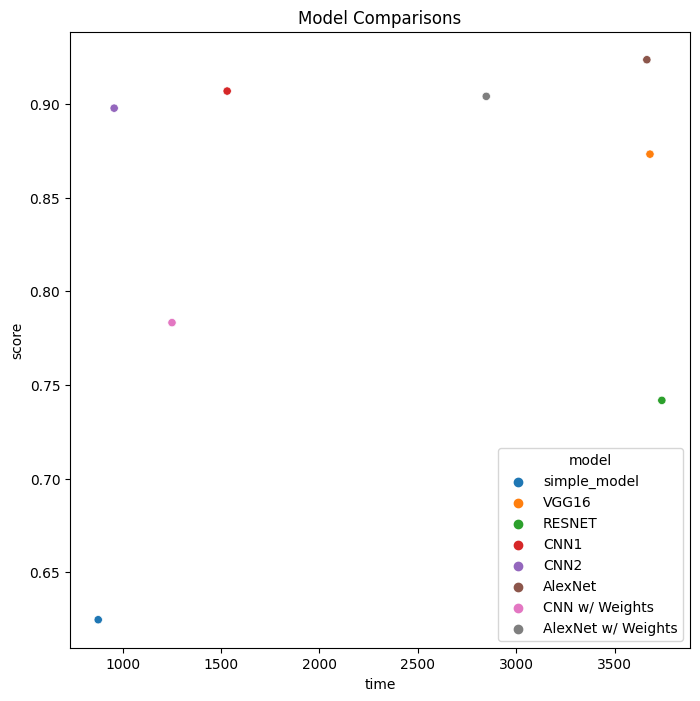

In [ ]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=results, x='time', y='score', hue='model', sizes='total_param')
plt.title('Model Comparisons')

## Future testing: Importing images from Google for testing

<class 'PIL.Image.Image'>
None
RGB
(128, 128)


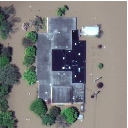

In [ ]:
# example of loading an image with the Keras API
from keras.preprocessing import image
# load the image
flood_img = image.load_img('/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/test_images/mi_flooded.jpg', target_size=(128,128))
# report details about the image
print(type(flood_img))
print(flood_img.format)
print(flood_img.mode)
print(flood_img.size)
# show the image
flood_img

<class 'PIL.Image.Image'>
None
RGB
(128, 128)


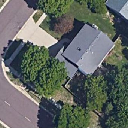

In [ ]:
# load the image
noflood1_img = image.load_img('/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/test_images/moms_house.jpg', target_size=(128,128))
# report details about the image
print(type(noflood1_img))
print(noflood1_img.format)
print(noflood1_img.mode)
print(noflood1_img.size)
# show the image
noflood1_img

<class 'PIL.Image.Image'>
None
RGB
(128, 128)


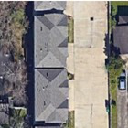

In [ ]:
# load the image
noflood2_img = image.load_img('/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/test_images/my_house.jpg', target_size=(128,128))
# report details about the image
print(type(noflood2_img))
print(noflood2_img.format)
print(noflood2_img.mode)
print(noflood2_img.size)
# show the image
noflood2_img

<class 'PIL.Image.Image'>
None
RGB
(128, 128)


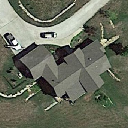

In [ ]:
# load the image
noflood3_img = image.load_img('/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/test_images/works_farm.jpg', target_size=(128,128))
# report details about the image
print(type(noflood3_img))
print(noflood3_img.format)
print(noflood3_img.mode)
print(noflood3_img.size)
# show the image
noflood3_img

In [ ]:
# For later prediction
# Load json and create model
json_file = open('/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/cnnweighted_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
cnn_model = model_from_json(loaded_model_json)
# load weights into new model
cnn_model.load_weights('/content/drive/MyDrive/09_Thinkful/03_Capstone-Projects/04_Final_Capstone/models/cnnweighted_model_weights.h5')
print("Loaded model from disk")

Loaded model from disk


### RESULTS

Comparing confusion matrices between models and looking at accuracy scores and run times, the AlexNet model provides the best results for predicting both the majority and the minority classes. The recall values for damage and no_damge are .89 and .92, respectively.

### CHALLENGES 

The biggest challenge I faced during this project was dealing with what I assume is data leakage in the model. Comparing the model results on the training data and the test data, there are some interesting descrepancies 

### FUTURE WORK

* Testing models with images from Google Earth and Google Images
* Additional adjustment of AlexNet and CNN Model #2 to improve performance of models
* Dashboard build in Ploty/Dash
* Web based app using Heroku

### DEPLOYMENT

This model could be deployed in a couple of different ways. It could be deployed at scale as an ArcGIS module that could be applied to larger satellite imagery sets. I assume this would be the best way to implement for a large insurance company or the federal government. A simpler way to deploy this model would be to build a web based image classification app using Heroku. The premise of this app would be that you input your own satelite image and the app will tell you if it is damaged or not. A potential downside to this approach is that if you put in an image that does not have a building with or without damage, the app will likely not understand that the image is not a damage/no_damage home and provide a incorrect classification.

### SOURCES
[1] Original Dataset: https://ieee-dataport.org/open-access/detecting-damaged-buildings-post-hurricane-satellite-imagery-based-customized

[2] Original Dataset paper: https://arxiv.org/abs/1807.01688

[3] Kaggle Dataset: https://www.kaggle.com/kmader/satellite-images-of-hurricane-damage

[4] Nasa Climate Change Research: https://climate.nasa.gov/

[5] Western US Fires: https://climate.nasa.gov/blog/3066/the-climate-connections-of-a-record-fire-year-in-the-us-west/

[6] Rising Sea Levels (Kiribati): https://www.nytimes.com/2016/07/03/world/asia/climate-change-kiribati.html

[7] Hurricane Harvey facts: https://tdem.texas.gov/hurricane-harvey-dr-4332-2/c

[8] Texas counties shapefile (TXDOT): https://gis-txdot.opendata.arcgis.com/datasets/texas-county-boundaries-detailed/explore?location=31.168805%2C-100.077018%2C6.70

[9] Guide to CNN: https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

[10] Kaggle Computer Vision Course: https://www.kaggle.com/learn/computer-vision

[11] IBM Computer Vision Explaination: https://www.ibm.com/topics/computer-vision

[12] IBM CNN Explaination: https://www.ibm.com/cloud/learn/convolutional-neural-networks

